In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
import datetime
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
data_orig = pd.read_csv("complete_2018_complaints.csv", parse_dates = ['Created Date', 'Closed Date'])

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (8,17,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
db = data_orig

In [5]:
#convert created and closed date columns to datetime, create new column called response time
db['Created Date'] = pd.to_datetime(db['Created Date'],errors = 'coerce')
db['Closed Date'] = pd.to_datetime(db['Closed Date'],errors = 'coerce')
db['Response Time'] = db['Closed Date'] - db['Created Date']

In [6]:
#make all timedelta series into floats of total hours, remove all rows with NaN response_time
db['response_time_days'] = [i.total_seconds()/86400.0 for i in db['Response Time']]
db['response_time_hours'] = [i.total_seconds()/3600.0 for i in db['Response Time']]
db['response_time_minutes'] = [i.total_seconds()/60.0 for i in db['Response Time']]
db['response_time_seconds'] = [i.total_seconds() for i in db['Response Time']] 
db = db[db['Response Time'].notnull()]

In [7]:
#create a new binary column reflecting whether a complaint took fewer than 2 minutes to resolve
def less_than(time):
    if time <= 120.0:
        return 1
    else:
        return 0

db['under_120'] = list(map(lambda x: less_than(x), db['response_time_seconds'])) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [8]:
#remove rows without a resolution description, make all resolution descriptions lower
db['Resolution Description']= db['Resolution Description'].replace(np.nan, 'unknown', regex=True)
db['Resolution Description'] = db['Resolution Description'].str.lower()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
#create a categorical column that provides a summarized description of the resolution description - used to group
#and analyze resolution descriptions

dno = ['did not observe', 'not able to gain access','could not find the problem', 'were gone','found no condition'\
      , 'no indication', 'no evidence', 'not find', 'unable to gain entry','no graffiti was found', 'could not locate',\
      'unable to find','attempted to investigate this complaint']

no_action_taken = ['determined that no further action was necessary','condition meets its standards',\
                  'no sewer back up', 'at this time', 'no action', 'not necessary','had been restored',\
                  'found it to be a temporary','inspected the location more than six months ago',\
                  'conflicts with surrounding infrastructure','did not have enough information',\
                  'an inside condition','closed or canceled this complaint','insufficient information',\
                  'does not meet the criteria','no further action is required','did not have sufficient information',\
'no work order was necessary','did not meet the criteria','unable to schedule a sidewalk', 'no violation',\
                  'not have sufficient', 'ineligible', 'was cancelled', 'in compliance with standards', 'was in compliance',\
                  'not enough information']

under_review_wait = ['will review your complaint',' will contact you', 'asked the department of', 'further investigation is required',\
                    'timeframe for repair work depends','has been scheduled', 'will inspect', \
                    'will contact you','a report was prepared','complaint conditions are still open',\
                    'will perform work to correct the condition','has sent official written','please check back later for status',\
                    'and will visit the location','will investigate the issue','usually requires 7 days to inspect',\
                    'usually requires 30 days to inspect','referred this complaint','a location of concern',
                    'your report has been sent','has received and processed your complaint','the literature will be emailed',\
                    'will review this service request','in the process of investigating','scheduled an inspection',\
                    'garage or bureau for further action','will investigate the issue','approved the sidewalk re-inspection request',\
'usually requires 10 days to review a request','will clean the graffiti','has been forwarded',\
'please note your service request number for future reference','requires contact with the complainant','will be notified',\
'will investigate','will fulfill','will receive','an inspection is warranted','to respond to this type of complaint',\
'to evaluate this type of request','opened a repair order','will be planned','long term and vary','will  investigate', \
                     'temporarily', 'partially rectified', 'will review','will notify','has been filed', \
                     'further investigation','will note','under investigation','mailed you a complaint form']

violations = ['violations were issued', 'board violation', 'notice of violation','stop work order violation(s) issued', 'violation was issued']

fixed = ['repaired the problem','department of sanitation removed the items','corrected the','correct the', 'repaired',\
         'cleaned', 'addressed the issue','provided the assistance','removed the graffiti','will be addressed',\
         'offered services', 'condisions were corrected','shut the running hydrant', 'were corrected', 'you will receive',\
        'collected', 'resolved', 'researched this complaint', 'took action','issued a','the problem was fixed',\
        'work was performed','removed the stop work order','the literature has been mailed',\
        'complaint was not warranted','performed repair work','made a repair','outreach assistance was offered',\
'opened fire hydrants','picked up the items','if the condition returns','salted the area','updated its records',\
'to a hospital','has been completed', 'was addressed','owner refused', 'debris was obstructing', 'was mailed','have mailed',\
        'was placed','created a service request','created a service request','mailed the requested item',\
         'investigated this complaint and','sent a report']

ambiguous = ['see notes', 'find additional information', 'learn more','more information', \
             'researched your claim','asked the department',\
            'has notified the property owner','additional information below', 'violations were previously issued',\
             'currently not available','unknown']
wrong_agency = ['jurisdiction', 'referred it','referred it to']
dup = ['duplicate','previously reported by another','an open service request already exists']

def string_replace(string):
    if string == 'unknown':
        return string
    elif any(x in string for x in no_action_taken):
        return 'no_action_taken'
    elif any(x in string for x in under_review_wait):
        return 'ongoing'
    elif any(x in string for x in dno):
        return 'did_not_observe'
    elif any(x in string for x in violations):
        return 'violations_issued'
    elif any(x in string for x in fixed):
        return 'fixed'
    elif any(x in string for x in ambiguous):
        return 'ambiguous'
    elif any(x in string for x in wrong_agency):
        return 'wrong_agency'
    elif any(x in string for x in dup):
        return 'duplicate'
    else:
        return 'string'

db['res_desc'] = [string_replace(x) for x in db['Resolution Description']]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
#to see only complaint types with more than 1,500 complains
from collections import Counter
res_desc_lists = Counter(db['res_desc'])
res_desc_list=[]
for res, count in res_desc_lists.items():   
    if count > 1500:
        res_desc_list.append(res)
db_filtered = db[db['res_desc'].isin(res_desc_list)]
db_filtered = db[db['response_time_seconds']>120]

In [11]:
#aggregate by agency and complaint type to see long complaints
grouped_complaints = db_filtered.groupby(['Agency','Complaint Type'])
time_per_complain_type = grouped_complaints['response_time_days'].agg(['mean', 'std','count'])
time_per_complain_type= time_per_complain_type.reset_index()
time_per_complain_type_long = time_per_complain_type[
    (time_per_complain_type['mean']>=31)&(time_per_complain_type['count']>1000)].sort_values(by='mean', ascending=False).reset_index()
time_per_complain_type_long.to_csv('longest_complaint_times.csv')

In [12]:
# understand res_desc for each complaint type
agg = db_filtered.groupby(['Agency','Complaint Type','res_desc'])
aggregated_complaint_times = agg['response_time_hours'].agg(
    ['count','mean','std']).sort_values(by=['Agency','Complaint Type','count'], ascending=False)
aggregated_complaint_times['mean'] = list(map(lambda x: round(x/24,2), aggregated_complaint_times['mean']))
aggregated_complaint_times['std'] = list(map(lambda x: round(x/24,2), aggregated_complaint_times['std']))
aggregated_complaint_times_formatted = aggregated_complaint_times.reset_index()
aggregated_complaint_times_formatted.to_csv('2018_11_05_311_agg_complaint_times_2017_data.csv', sep = ',')

In [13]:
#understanding what percentage of total for each res_desc


outcome_rates = {'other': round(len(db[db['res_desc']=='string'])/len(db),3),\
'duplicate': round(len(db[db['res_desc']=='duplicate'])/len(db),3),\
'fixed':round(len(db[db['res_desc']=='fixed'])/len(db),3),\
'did_not_observe':round(len(db[db['res_desc']=='did_not_observe'])/len(db),3),\
'no_action_taken':round(len(db[db['res_desc']=='no_action_taken'])/len(db),3),\
'violations_issued':round(len(db[db['res_desc']=='violations_issued'])/len(db),3),\
'ambiguous':round(len(db[db['res_desc']=='ambiguous'])/len(db),3),\
'ongoing':round(len(db[db['res_desc']=='ongoing'])/len(db),3),\
'wrong_agency':round(len(db[db['res_desc']=='wrong_agency'])/len(db),3),\
'fixed_or_violations_issued':round(len(db[db['res_desc']=='violations_issued']+db[db['res_desc']=='fixed'])/len(db),2),\
'did_not_observe_or_no_action_taken':round(len(db[db['res_desc']=='no_action_taken']+db[db['res_desc']=='did_not_observe'])/len(db),2)}


print(outcome_rates)

{'other': 0.004, 'duplicate': 0.055, 'fixed': 0.215, 'did_not_observe': 0.248, 'no_action_taken': 0.187, 'violations_issued': 0.048, 'ambiguous': 0.1, 'ongoing': 0.062, 'wrong_agency': 0.008, 'fixed_or_violations_issued': 0.26, 'did_not_observe_or_no_action_taken': 0.44}


In [14]:
#creating df that shows response time by agency
resp_by_agency = db_filtered.groupby('Agency')['response_time_hours'].agg('mean').to_frame()
resp_by_agency = resp_by_agency.sort_values(by = 'response_time_hours', ascending=False).reset_index()#resp_by_agency.to_csv('2018_11_05_response_time_by_agency_2017_data.csv')

In [15]:
#shows breakdown of agency performance by borough
agency_list = ['NYPD','HPD','DOT','DSNY','DEP','DPR','DOB','DOF','DOHMH','DHS','TLC']
boards_complaint = db_filtered.groupby(['Community Board','Agency'])
board_agg = boards_complaint['response_time_hours'].agg(['count','mean','std']).sort_values(by = ['Community Board','Agency','mean','count'])
board_agg = board_agg[board_agg['count']>100]
boards_agg_df = board_agg.reset_index()
boards_agg_df = boards_agg_df.query('Agency in @agency_list')
boards_agg_df = boards_agg_df[boards_agg_df['Community Board'].str.contains('Unspecified') ==False]
boards_agg_df= boards_agg_df.sort_values(by= 'Community Board')

In [16]:
def join(string):
    string = string.split(' ')
    return string[1]+' '+string[0]

boards_agg_df['Community Board'] = list(map(lambda x: join(x), boards_agg_df['Community Board'])) 

In [17]:
agency_name_list = ['NYPD','HPD','DOT','DSNY','DEP','DPR','DOB','DOF','DOHMH','DHS','TLC']
boards_agg_df['mean'] = boards_agg_df['mean'].apply(np.log)


nypd = boards_agg_df[boards_agg_df['Agency']=='NYPD'].sort_values(by='Community Board')
hpd = boards_agg_df[boards_agg_df['Agency']=='HPD'].sort_values(by='Community Board')
dot = boards_agg_df[boards_agg_df['Agency']=='DOT'].sort_values(by='Community Board')
dsny = boards_agg_df[boards_agg_df['Agency']=='DSNY'].sort_values(by='Community Board')
dep = boards_agg_df[boards_agg_df['Agency']=='DEP'].sort_values(by='Community Board')
dpr = boards_agg_df[boards_agg_df['Agency']=='DPR'].sort_values(by='Community Board')
dob = boards_agg_df[boards_agg_df['Agency']=='DOB'].sort_values(by='Community Board')
dof = boards_agg_df[boards_agg_df['Agency']=='DOF'].sort_values(by='Community Board')
dohmh = boards_agg_df[boards_agg_df['Agency']=='DOHMH'].sort_values(by='Community Board')
dhs = boards_agg_df[boards_agg_df['Agency']=='DHS'].sort_values(by='Community Board')
tlc = boards_agg_df[boards_agg_df['Agency']=='TLC'].sort_values(by='Community Board')

agency_list = [nypd,hpd,dot,dsny,dep,dpr,dob,dof,dohmh,dhs,tlc]

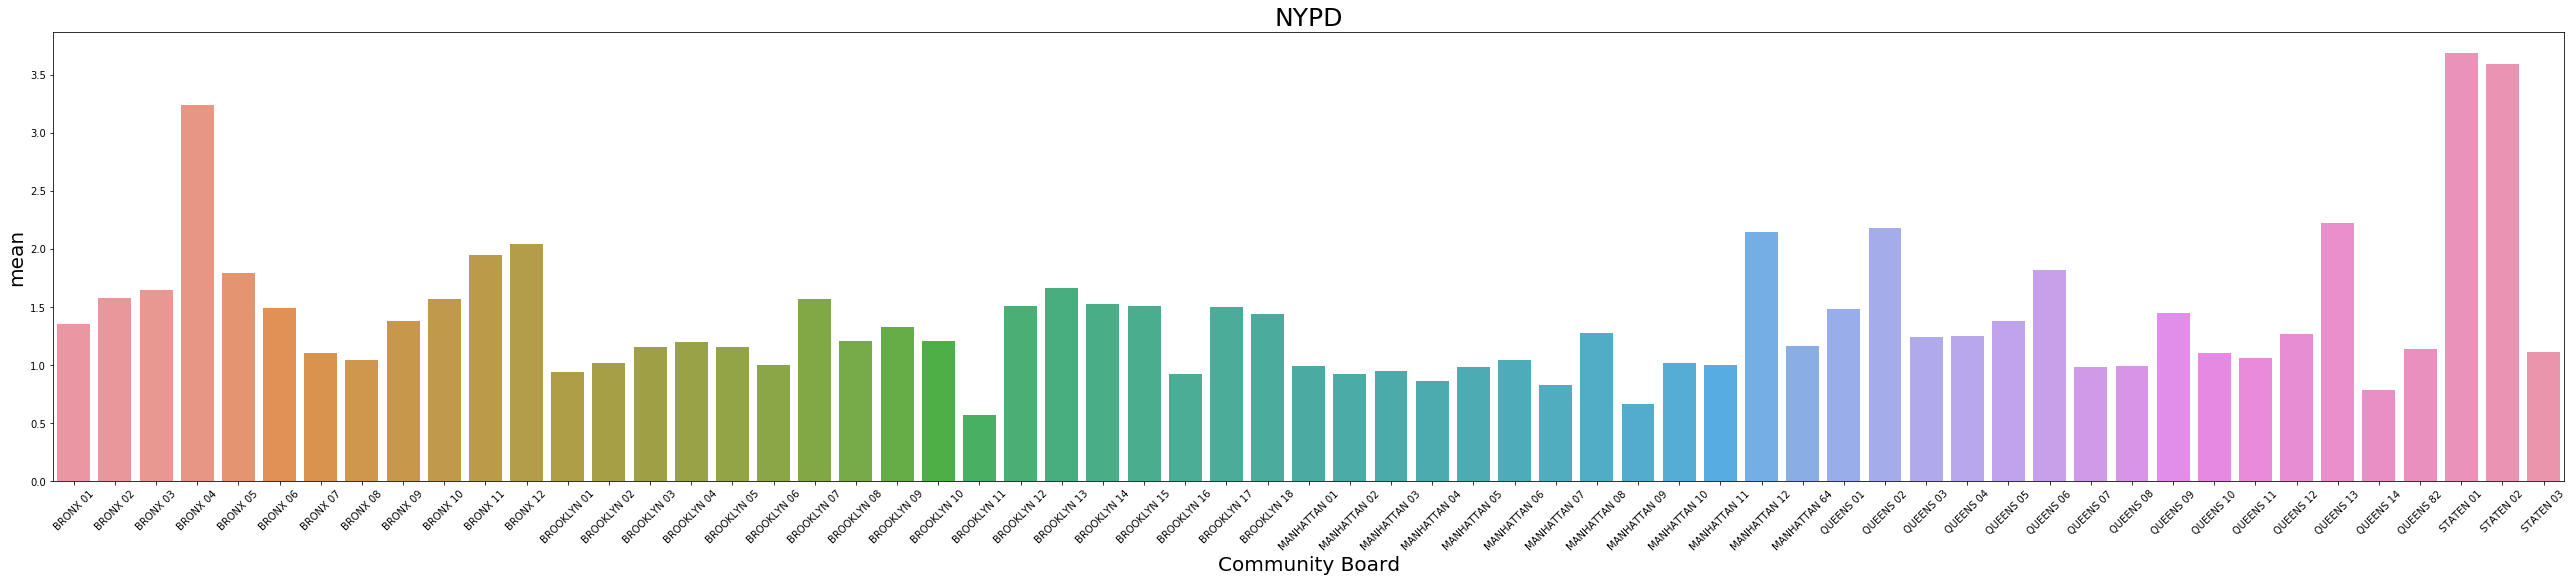

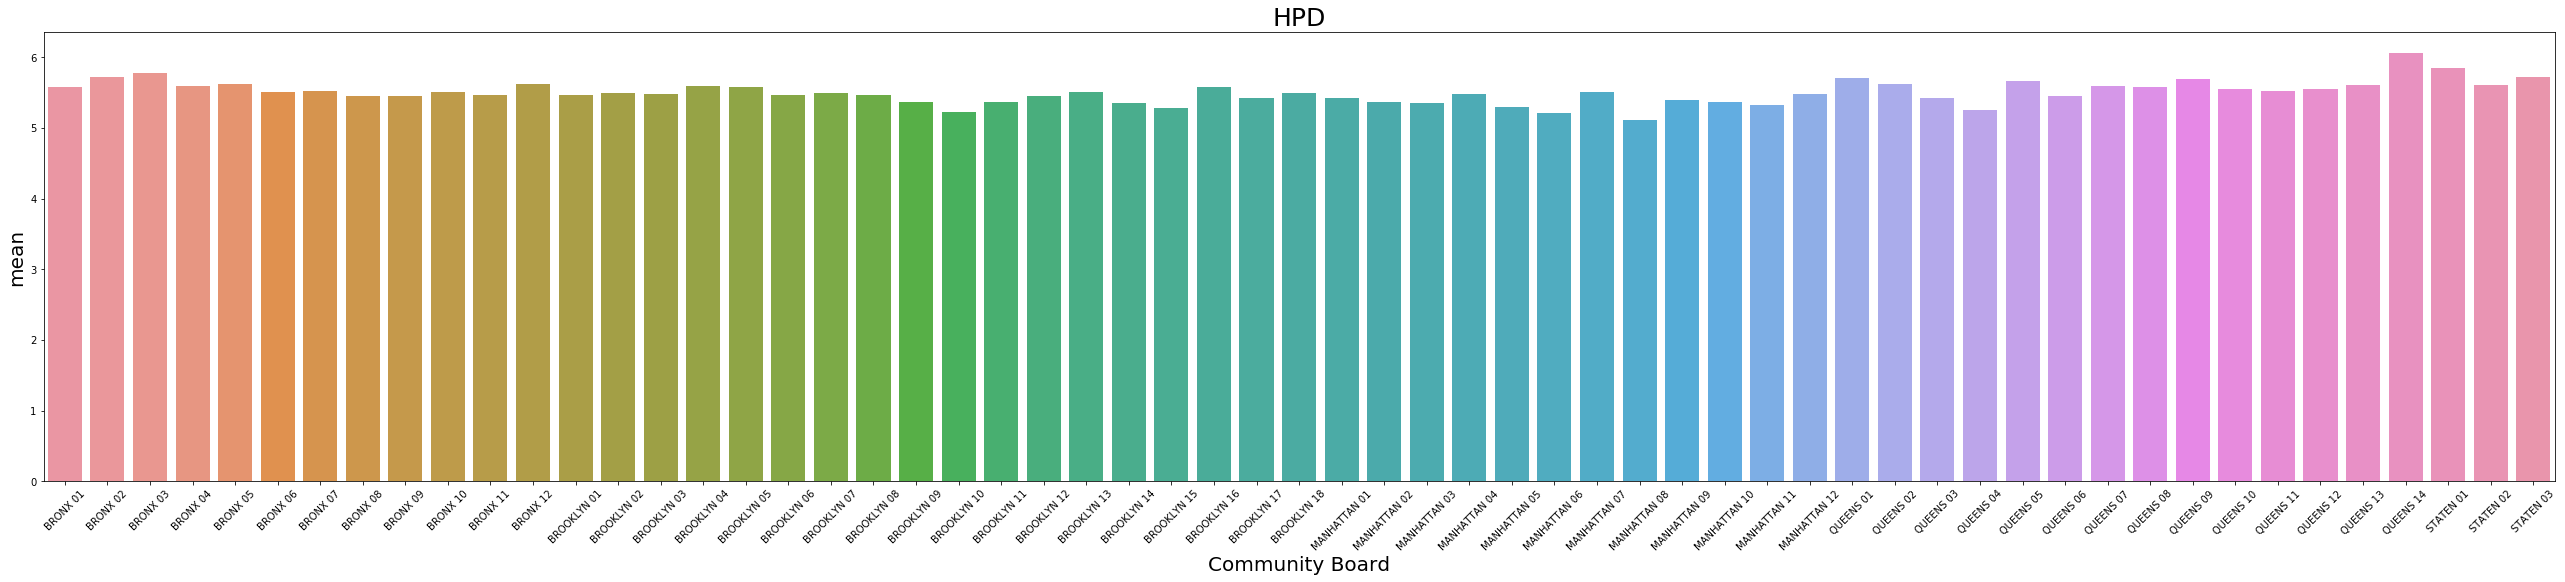

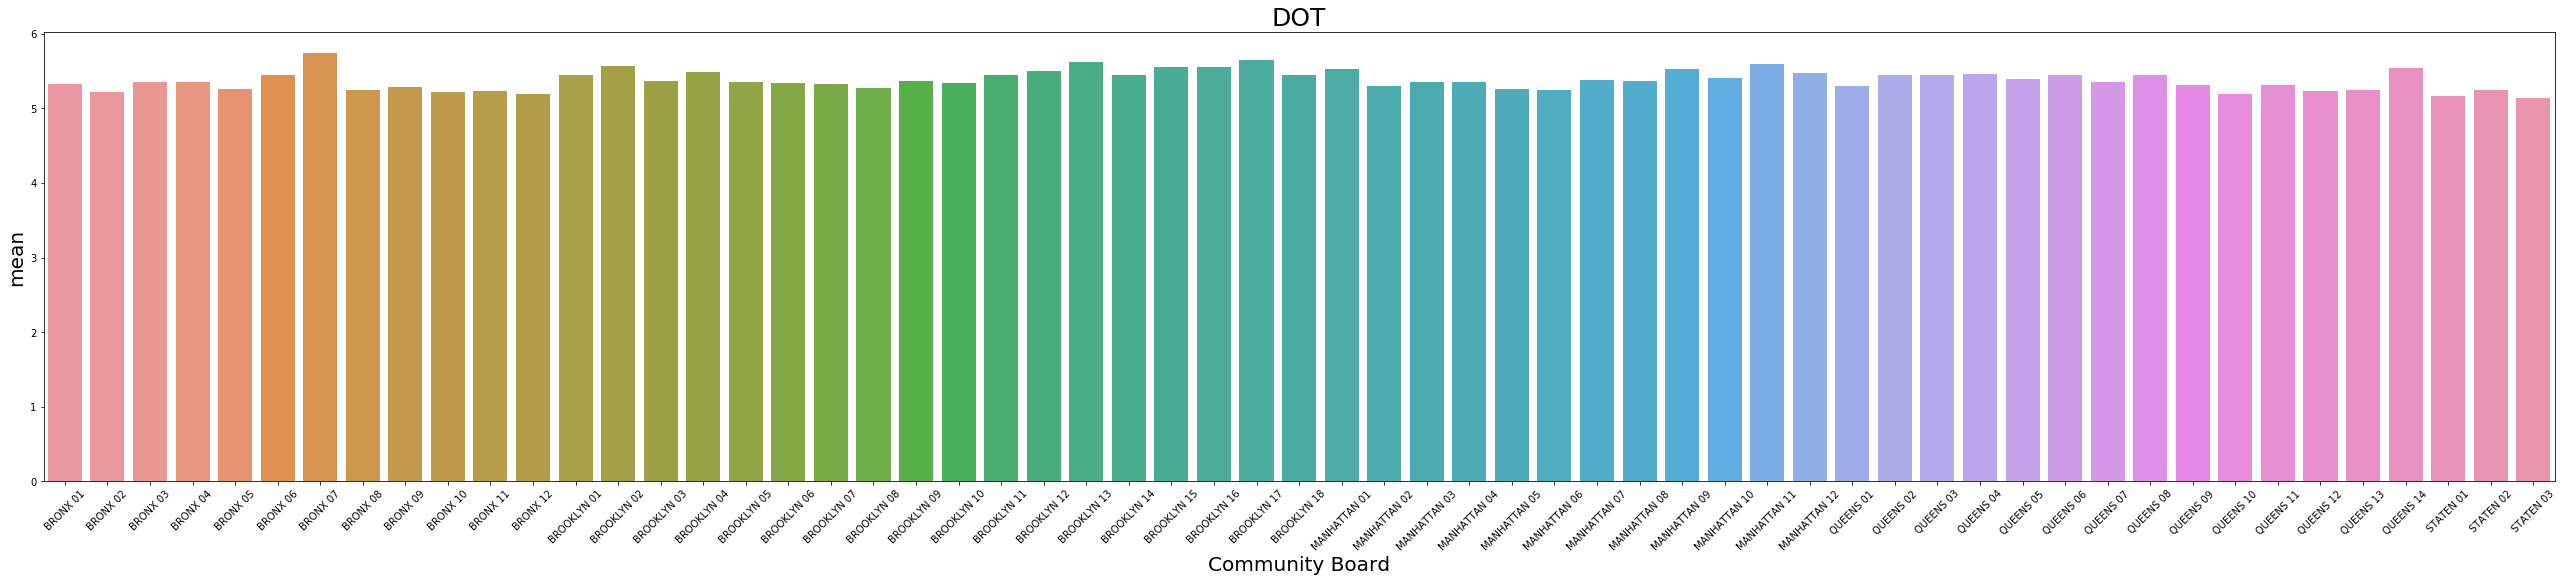

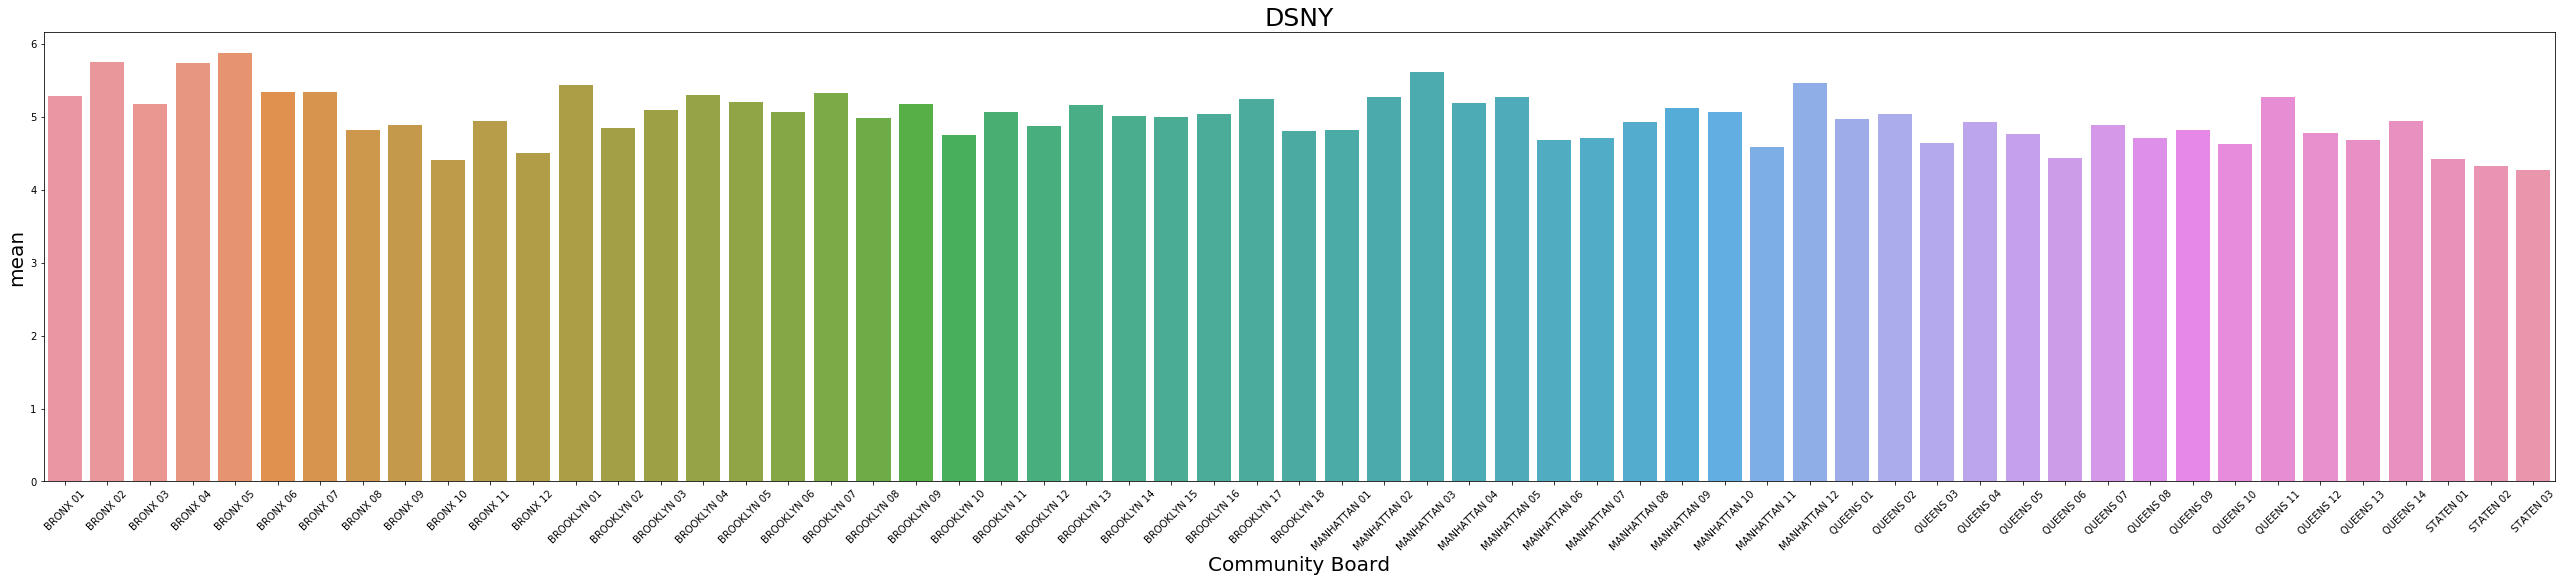

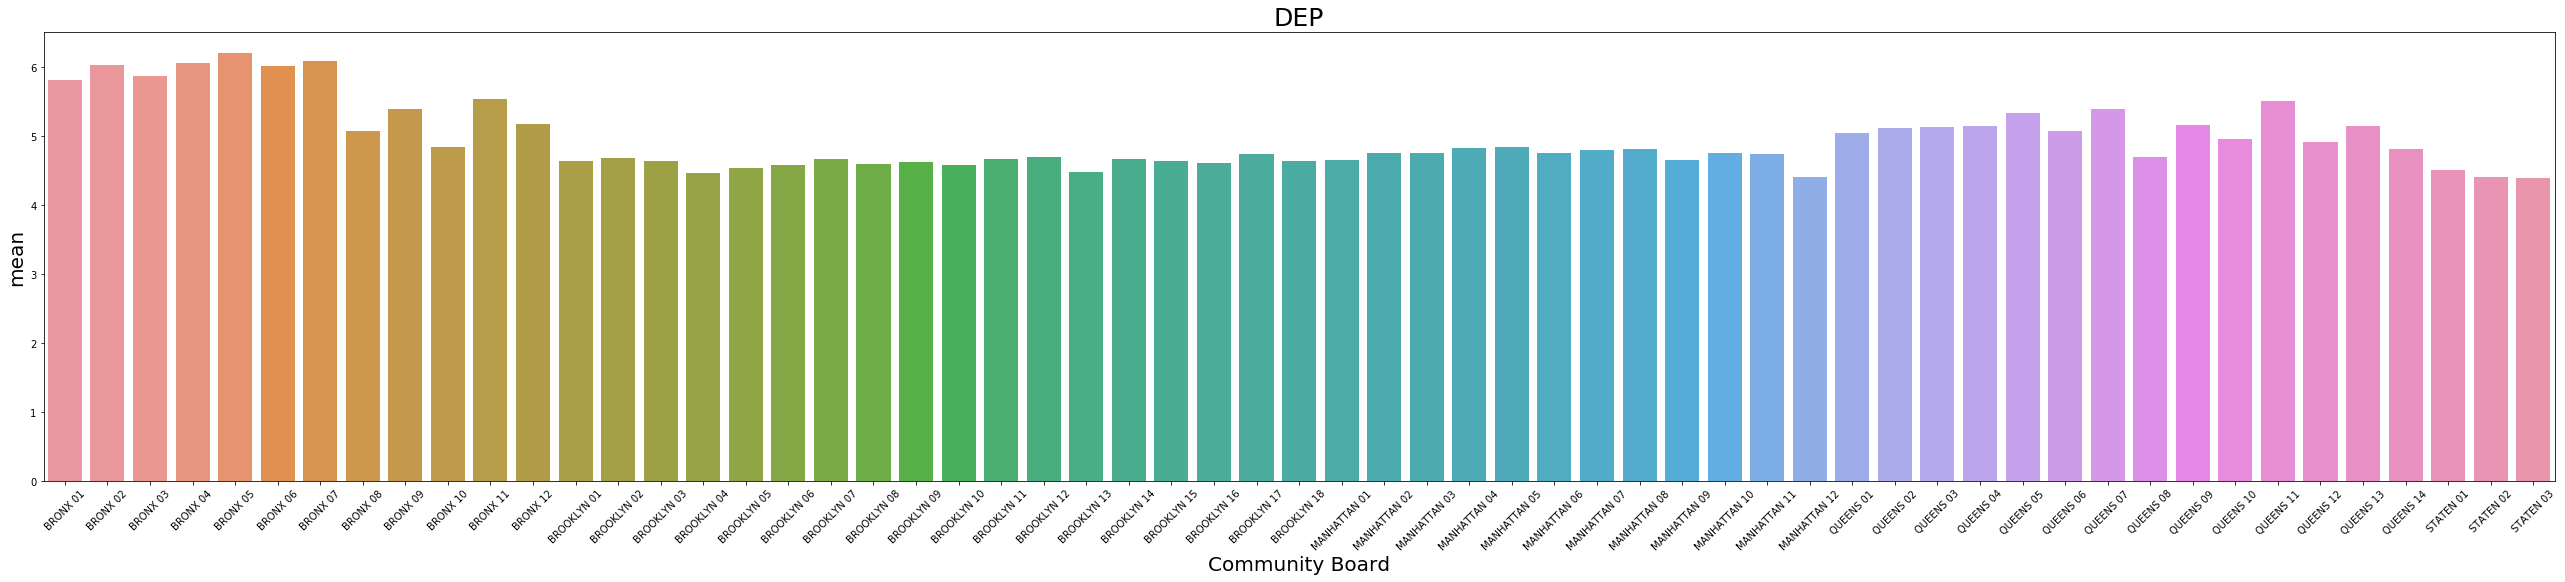

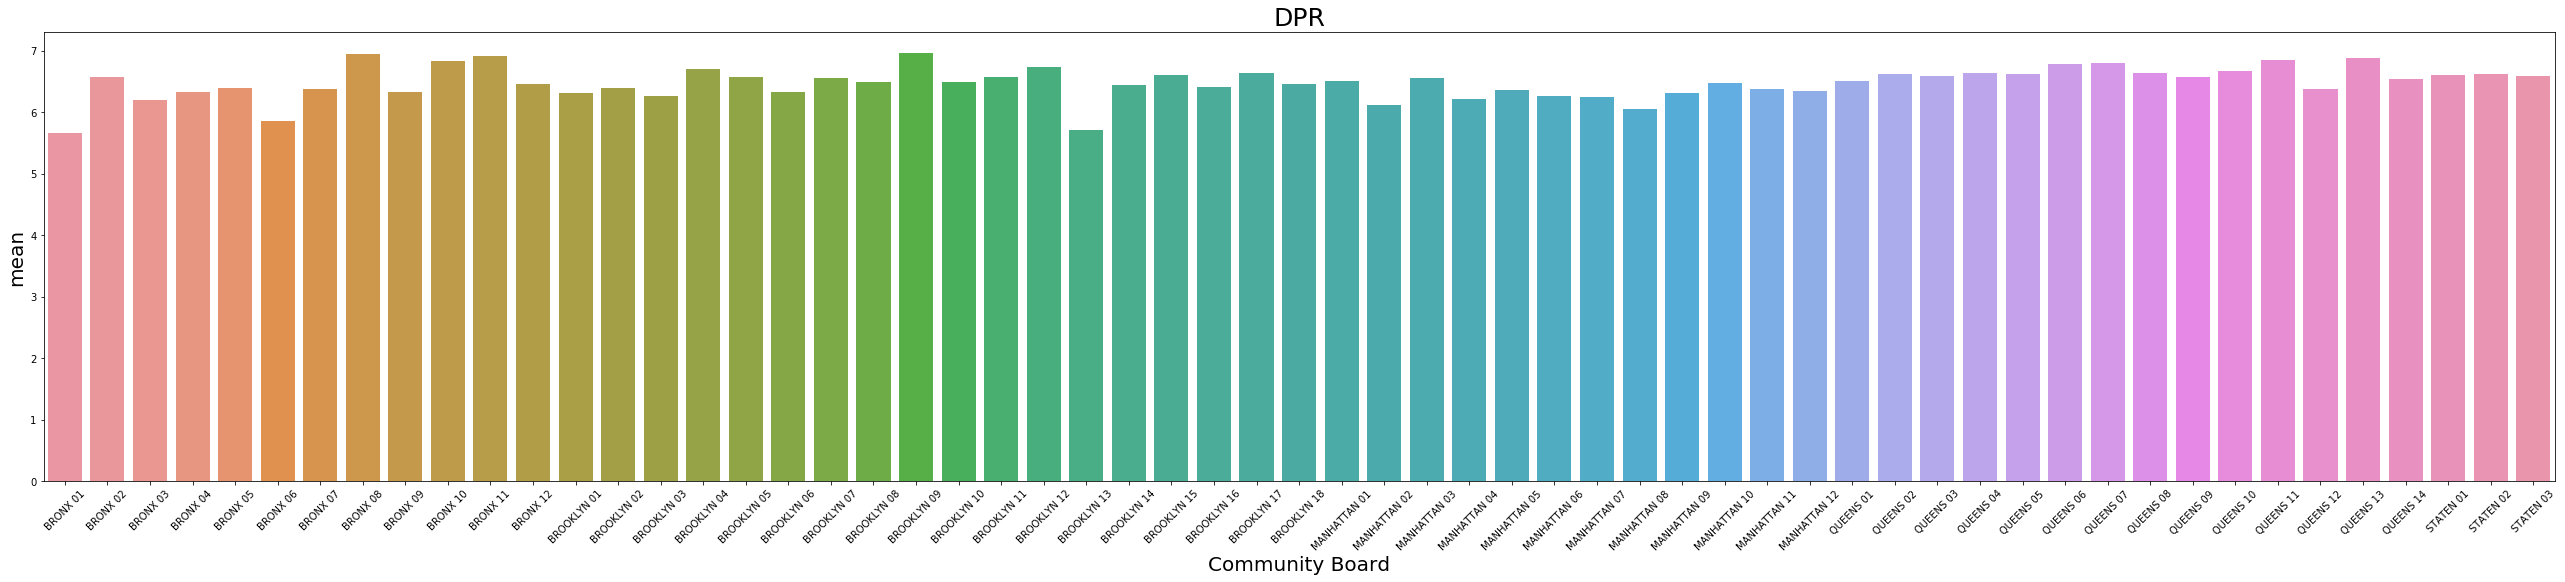

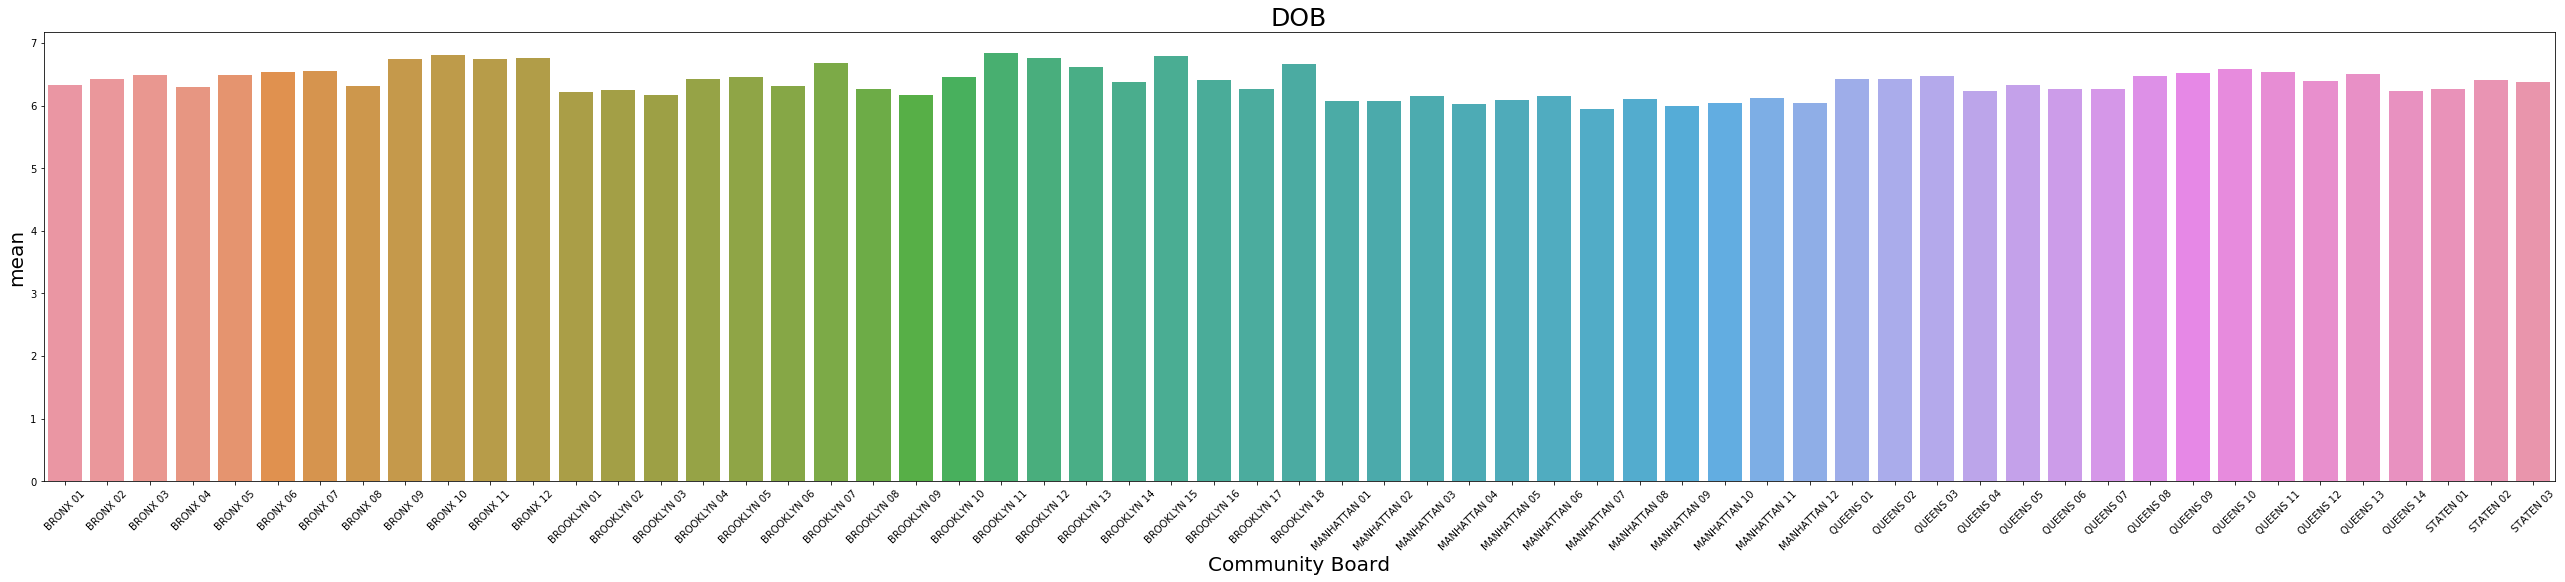

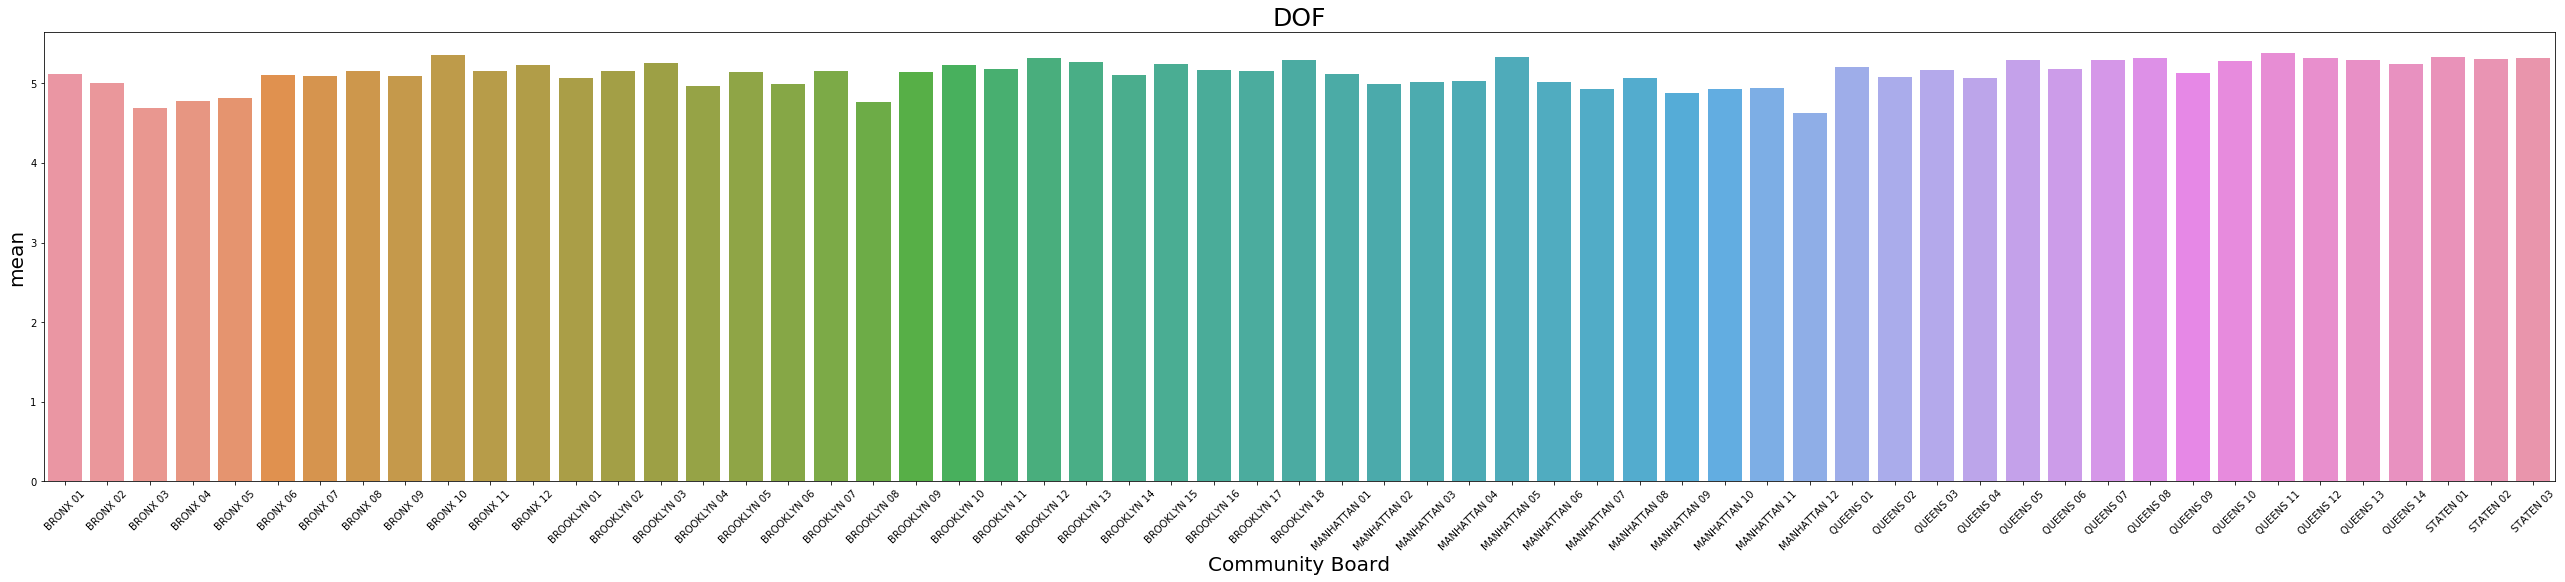

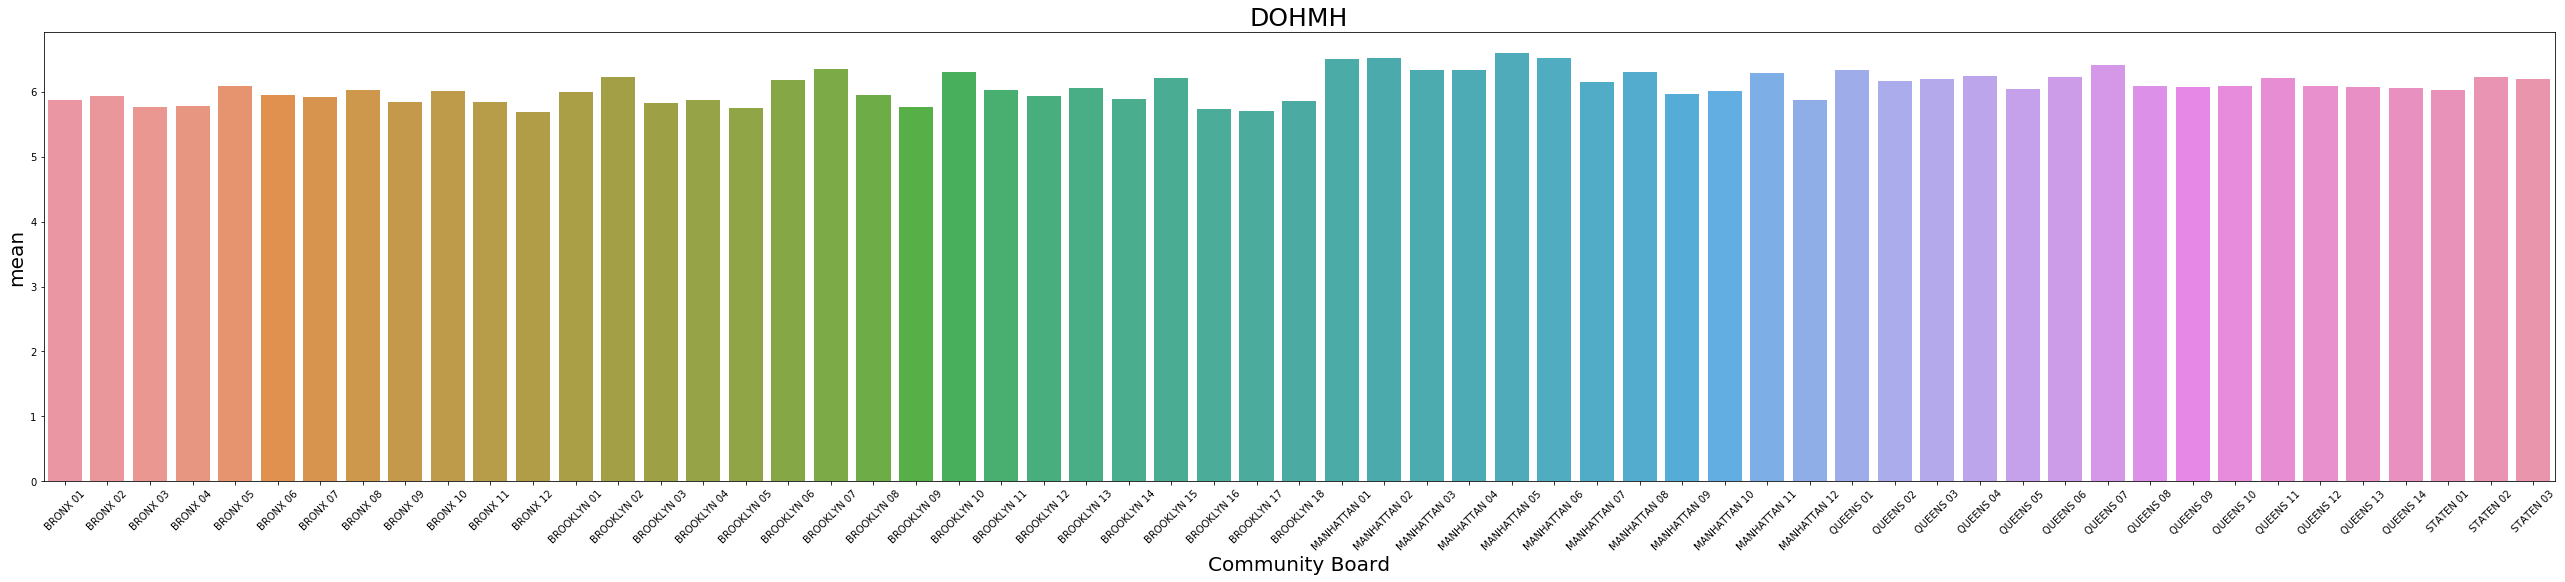

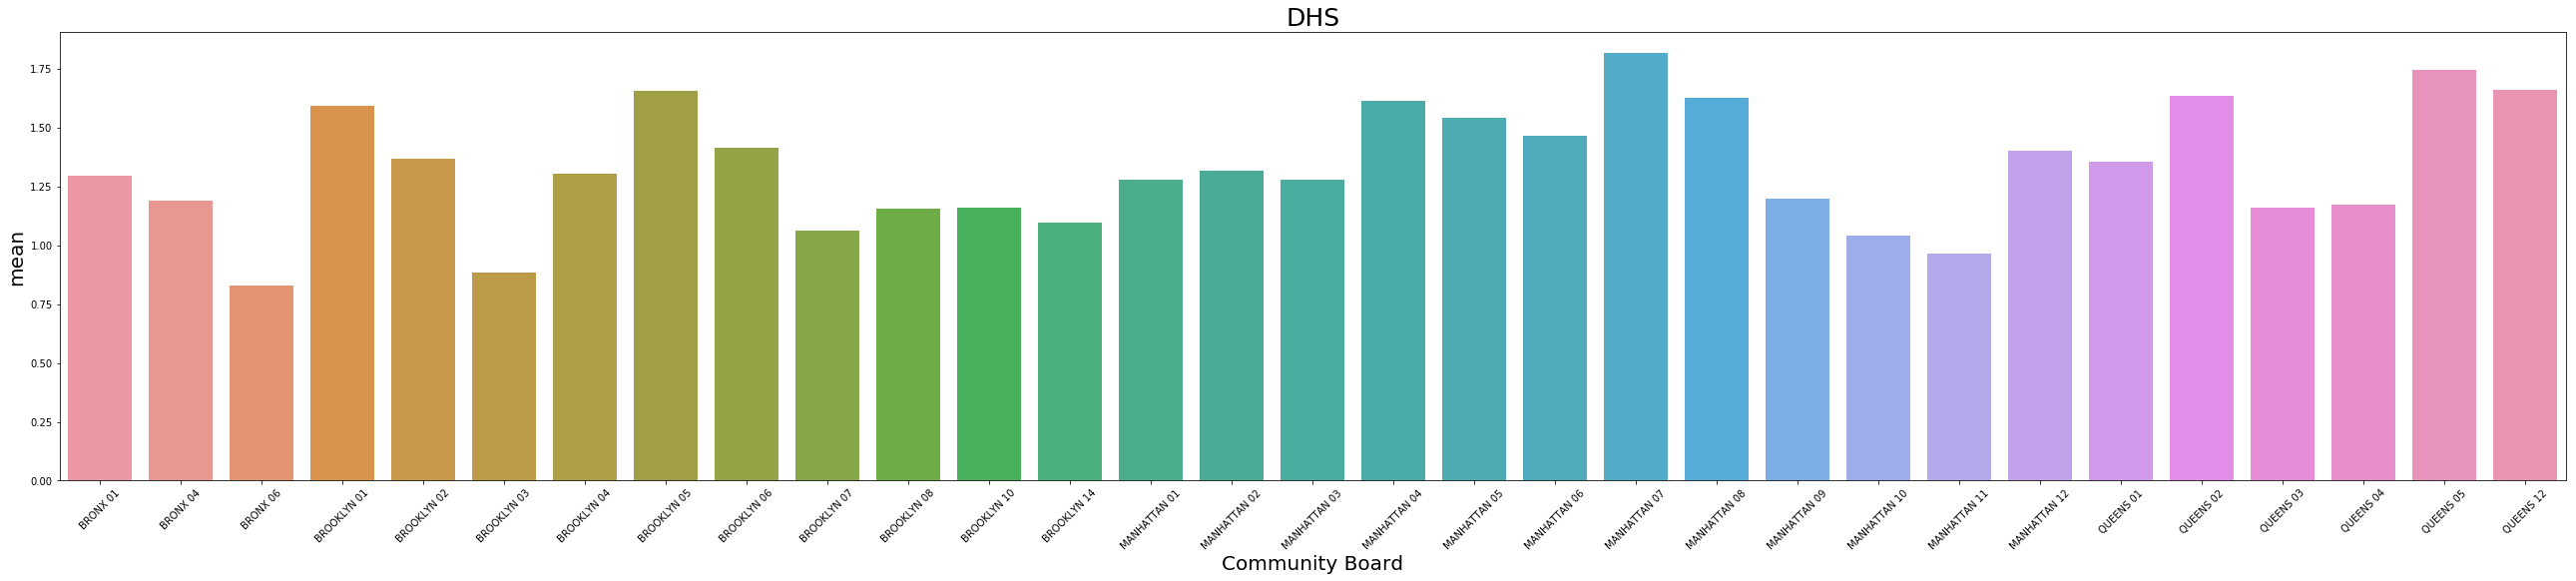

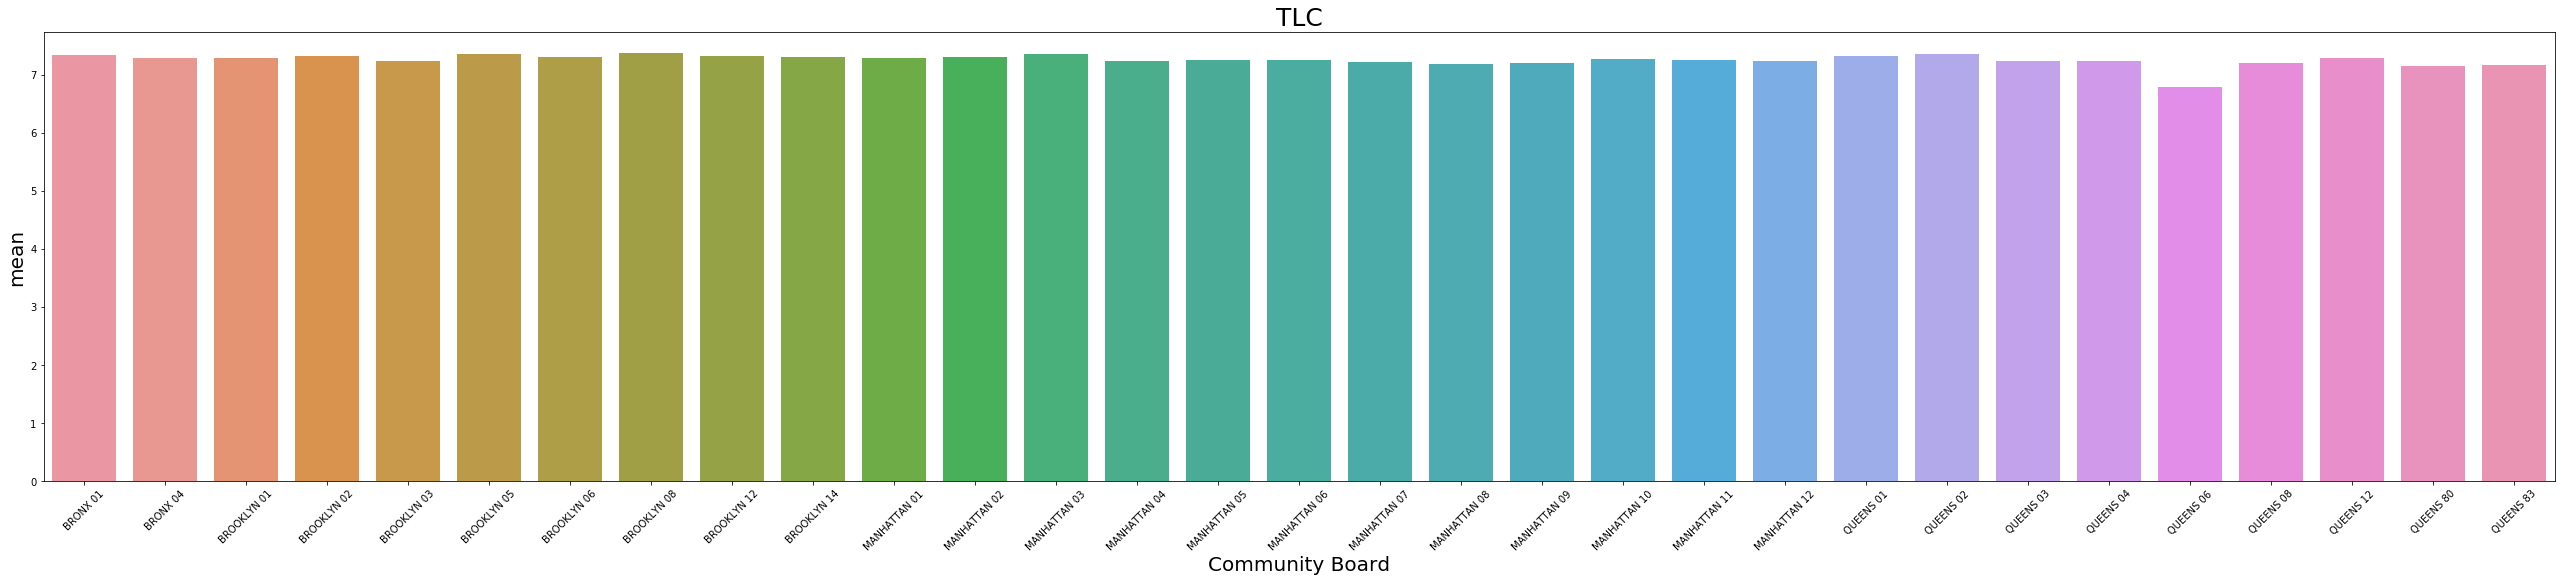

In [18]:
#visually breaks down agency performance by board
x= 'Community Board'
y= 'mean'
a4_dims = (45, 8.27)

for i in range(len(agency_list)):
    fig, ax = plt.subplots(figsize=a4_dims)
    ax.set_title(agency_name_list[i], fontsize=25)
    ax.set_xlabel("Community Board",fontsize=20)
    ax.set_ylabel("Mean Completion Time",fontsize=20)
    agencyboardplot = sns.barplot(x, y, data=agency_list[i], ax=ax)
    agencyboardplot.set_xticklabels(agencyboardplot.get_xticklabels(), rotation=45)


In [19]:
#looking at community board breakdown by complaint type so that we can take a closer look at what might be going on with NYPD Response times
boards_complaint_type = db_filtered.groupby(['Community Board','Agency','Complaint Type'])
board_comp_agg = boards_complaint_type['response_time_hours'].agg(['count','mean','std']).sort_values(by = ['Community Board','Agency','Complaint Type','mean','count'])
board_comp_agg = board_comp_agg[board_comp_agg['count']>100]
boards_comp_agg_df = board_comp_agg.reset_index()
boards_comp_agg_df = boards_comp_agg_df[boards_comp_agg_df['Community Board'].str.contains('Unspecified') ==False]
boards_comp_agg_df= boards_comp_agg_df.sort_values(by= 'Community Board')
boards_comp_agg_df['mean'] = boards_comp_agg_df['mean'].apply(np.log)
boards_comp_agg_df['Community Board'] = list(map(lambda x: join(x), boards_comp_agg_df['Community Board'])) 

In [20]:
nypd_comps = boards_comp_agg_df[boards_comp_agg_df['Agency']=='NYPD'].sort_values(by='Community Board')

In [28]:
illegal_parking = nypd_comps[nypd_comps['Complaint Type']=='Illegal Parking'].sort_values(by='Community Board')

noise_street_sidewalk = nypd_comps[nypd_comps['Complaint Type']=='Noise - Street/Sidewalk'].sort_values(by='Community Board')

noise_residential = nypd_comps[nypd_comps['Complaint Type']=='Noise - Residential'].sort_values(by='Community Board')

blocked_driveway = nypd_comps[nypd_comps['Complaint Type']=='Blocked Driveway'].sort_values(by='Community Board')

noise_vehicle = nypd_comps[nypd_comps['Complaint Type']=='Noise - Vehicle'].sort_values(by='Community Board')

noise_commercial = nypd_comps[nypd_comps['Complaint Type']=='Noise - Commercial'].sort_values(by='Community Board')

animal_abuse = nypd_comps[nypd_comps['Complaint Type']=='Animal Abuse'].sort_values(by='Community Board')

derelict_vehicle = nypd_comps[nypd_comps['Complaint Type']=='Derelict Vehicle'].sort_values(by='Community Board')

non_emergency_police_matter = nypd_comps[nypd_comps['Complaint Type']=='Non-Emergency Police Matter'].sort_values(by='Community Board')

noise_park = nypd_comps[nypd_comps['Complaint Type']=='Noise - Park'].sort_values(by='Community Board')

traffic = nypd_comps[nypd_comps['Complaint Type']=='Traffic'].sort_values(by='Community Board')

homeless_encampment = nypd_comps[nypd_comps['Complaint Type']=='Homeless Encampment'].sort_values(by='Community Board')

vending = nypd_comps[nypd_comps['Complaint Type']=='Vending'].sort_values(by='Community Board')

nypd_complaint_list = ['illegal_parking','noise_street_sidewalk','noise_residential','blocked_driveway','noise_vehicle',
                      'noise_commercial','animal_abuse','derelict_vehicle','non_emergency_police_matter','noise_park',
                      'traffic','homeless_encampment','vending']

nypd_complaints = [illegal_parking,noise_street_sidewalk,noise_residential,blocked_driveway,noise_vehicle,
                      noise_commercial,animal_abuse,derelict_vehicle,non_emergency_police_matter,noise_park,
                      traffic,homeless_encampment,vending]

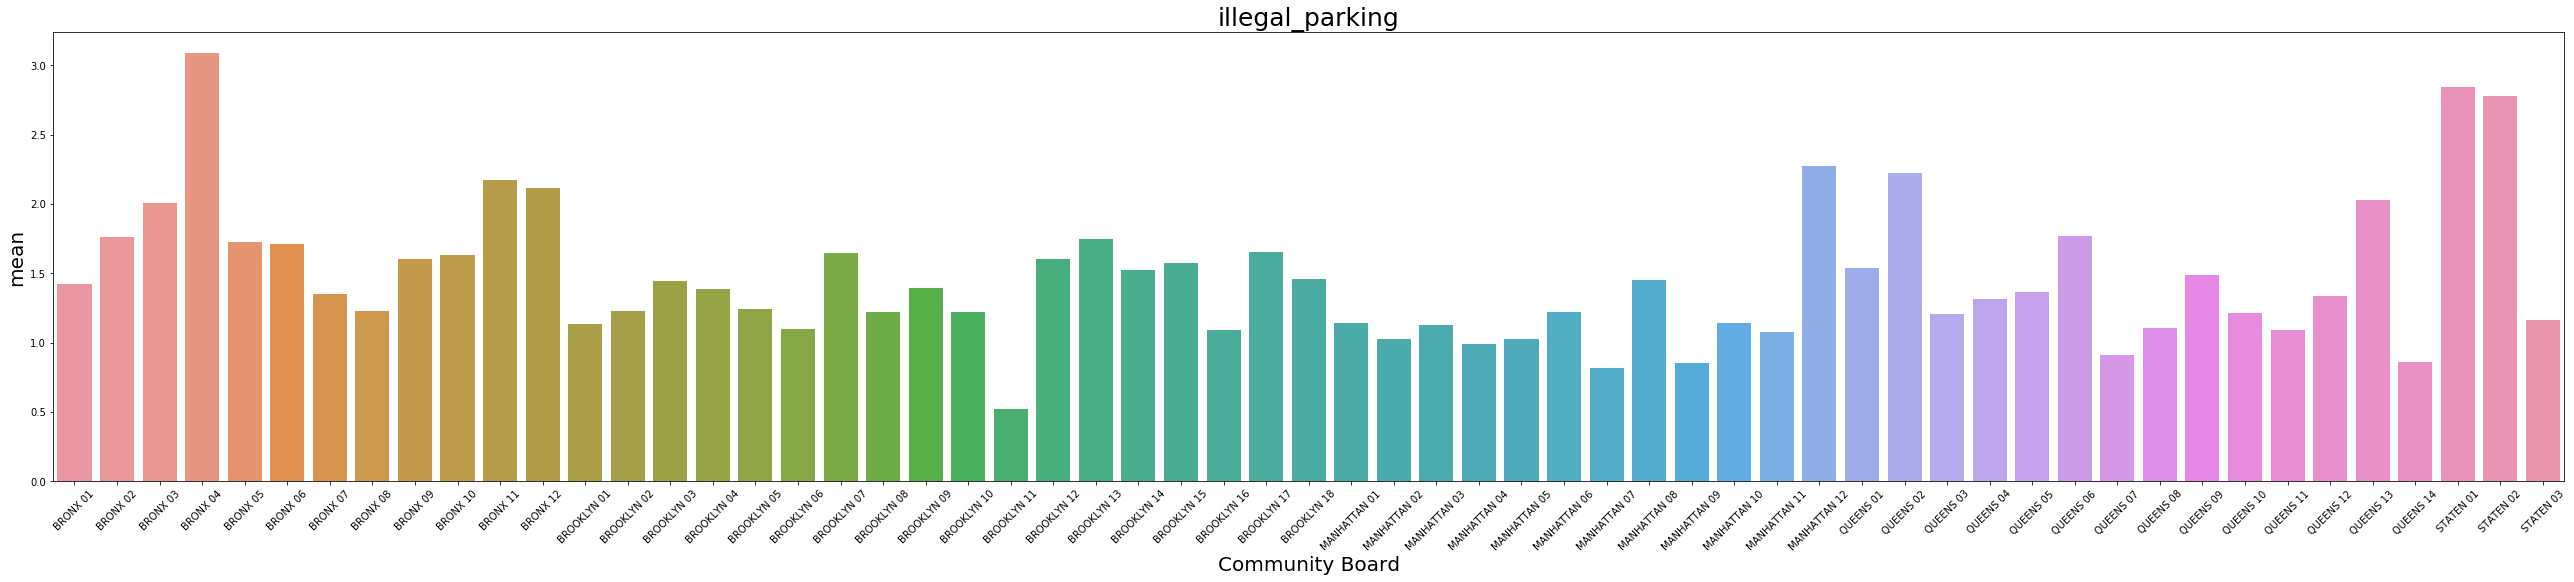

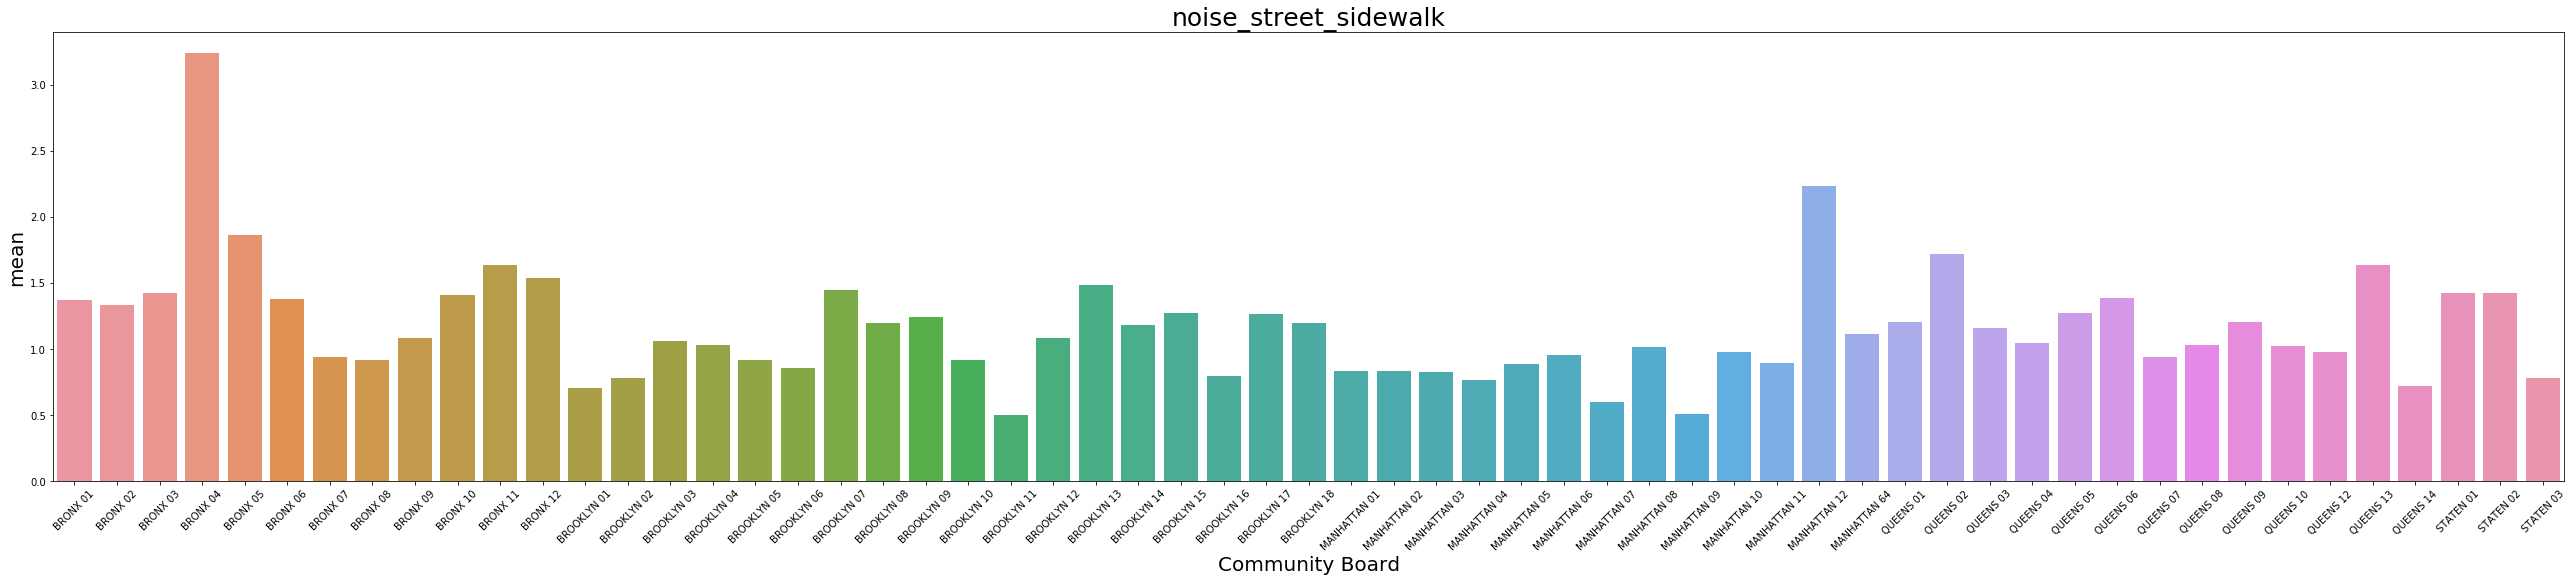

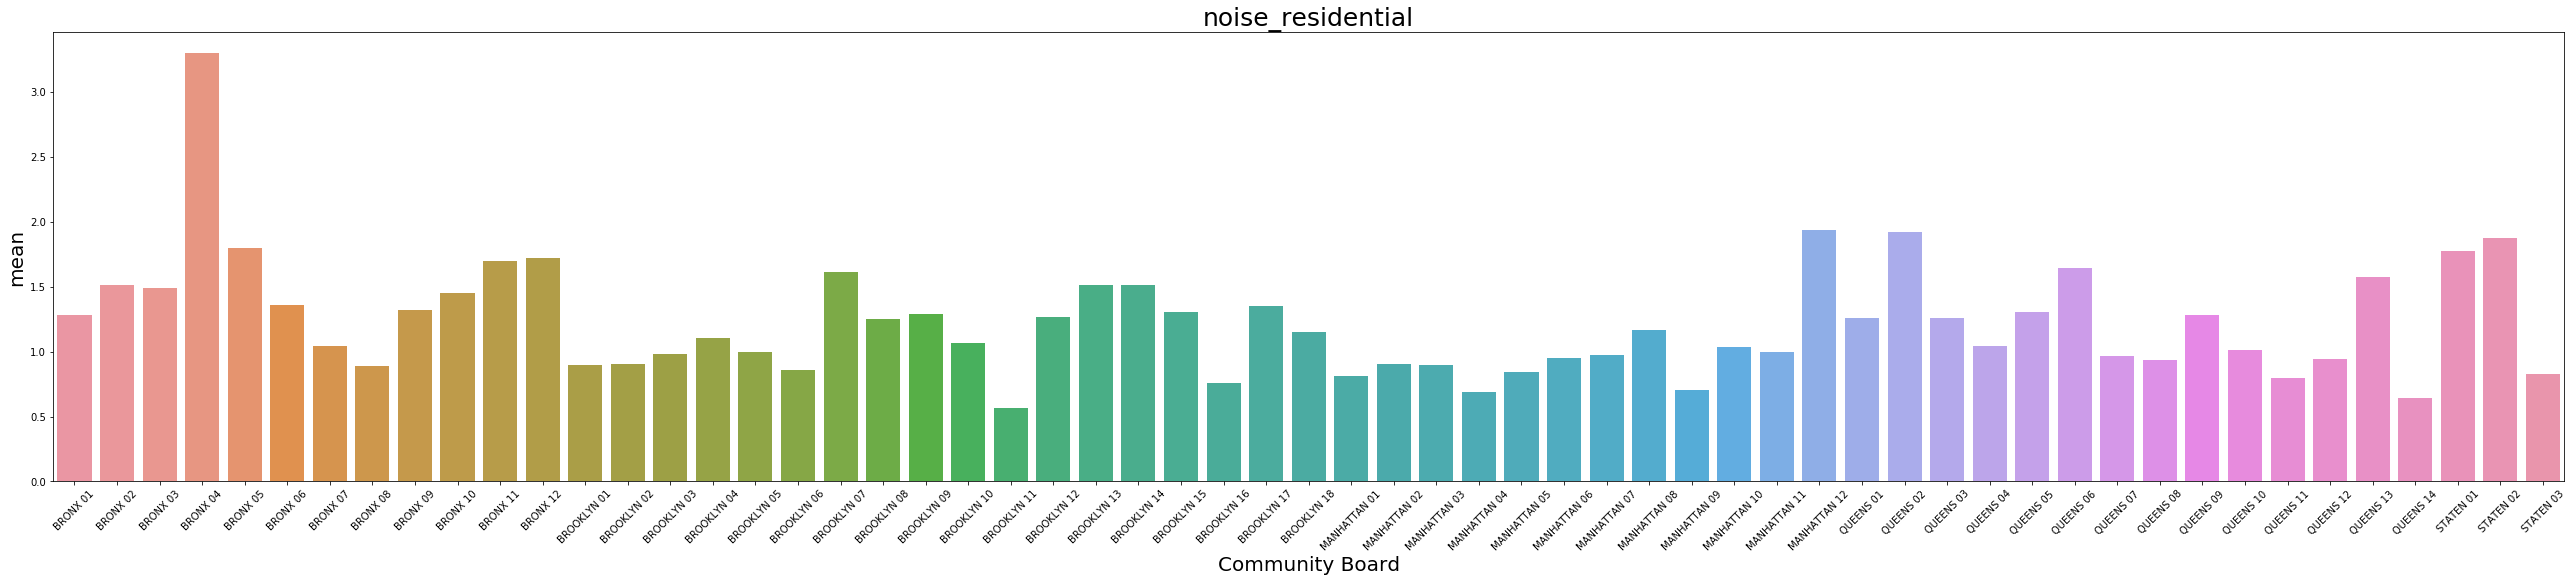

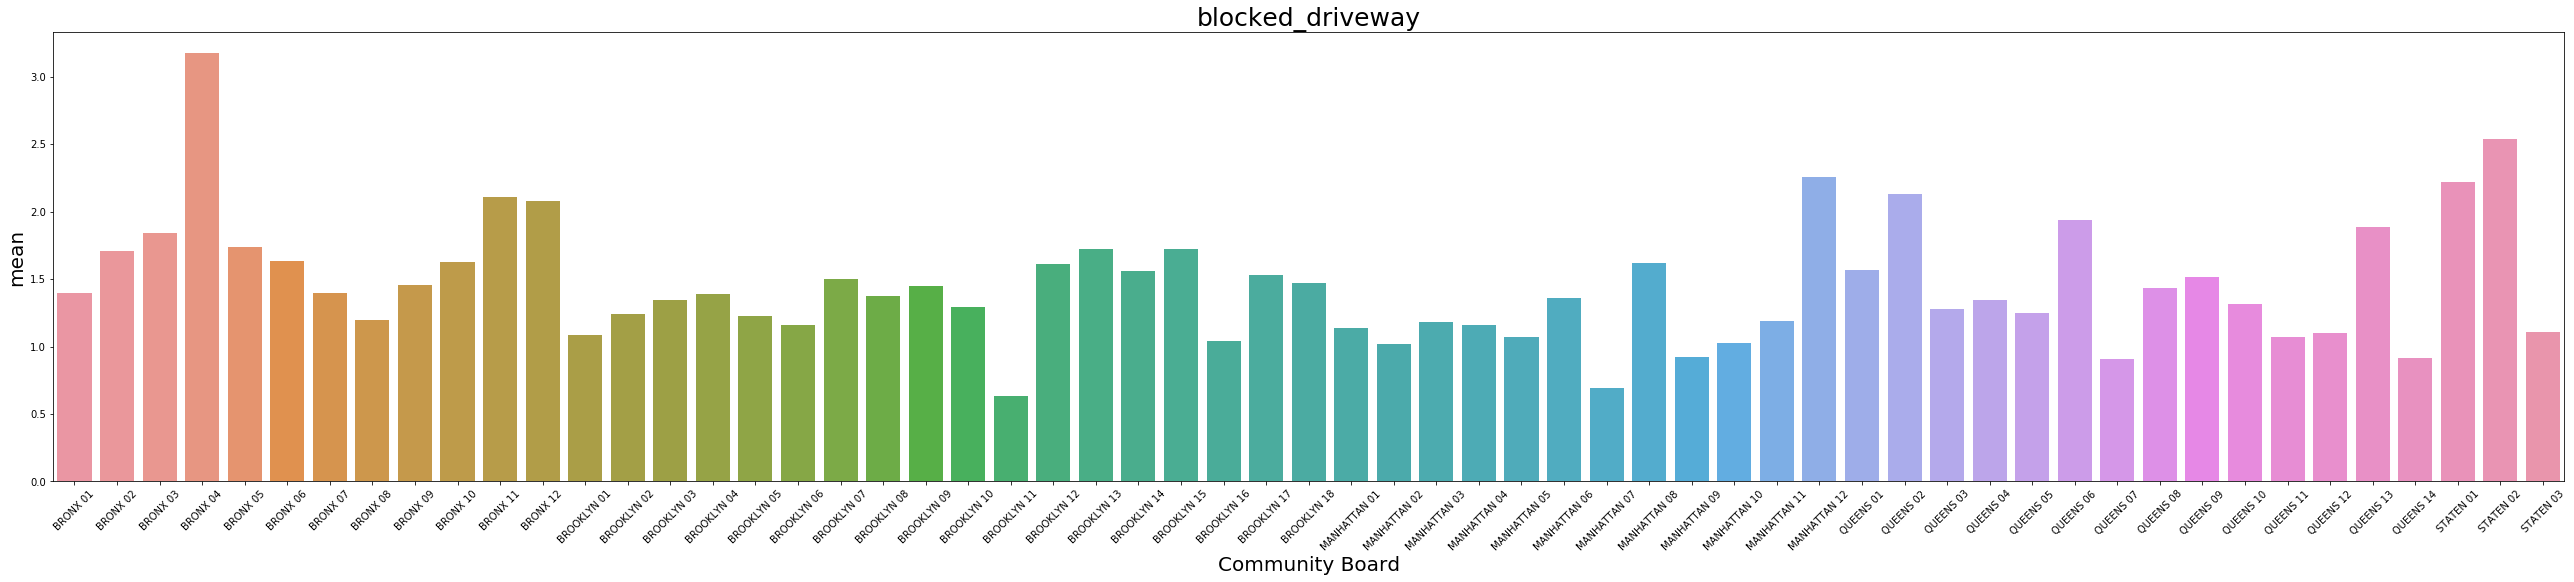

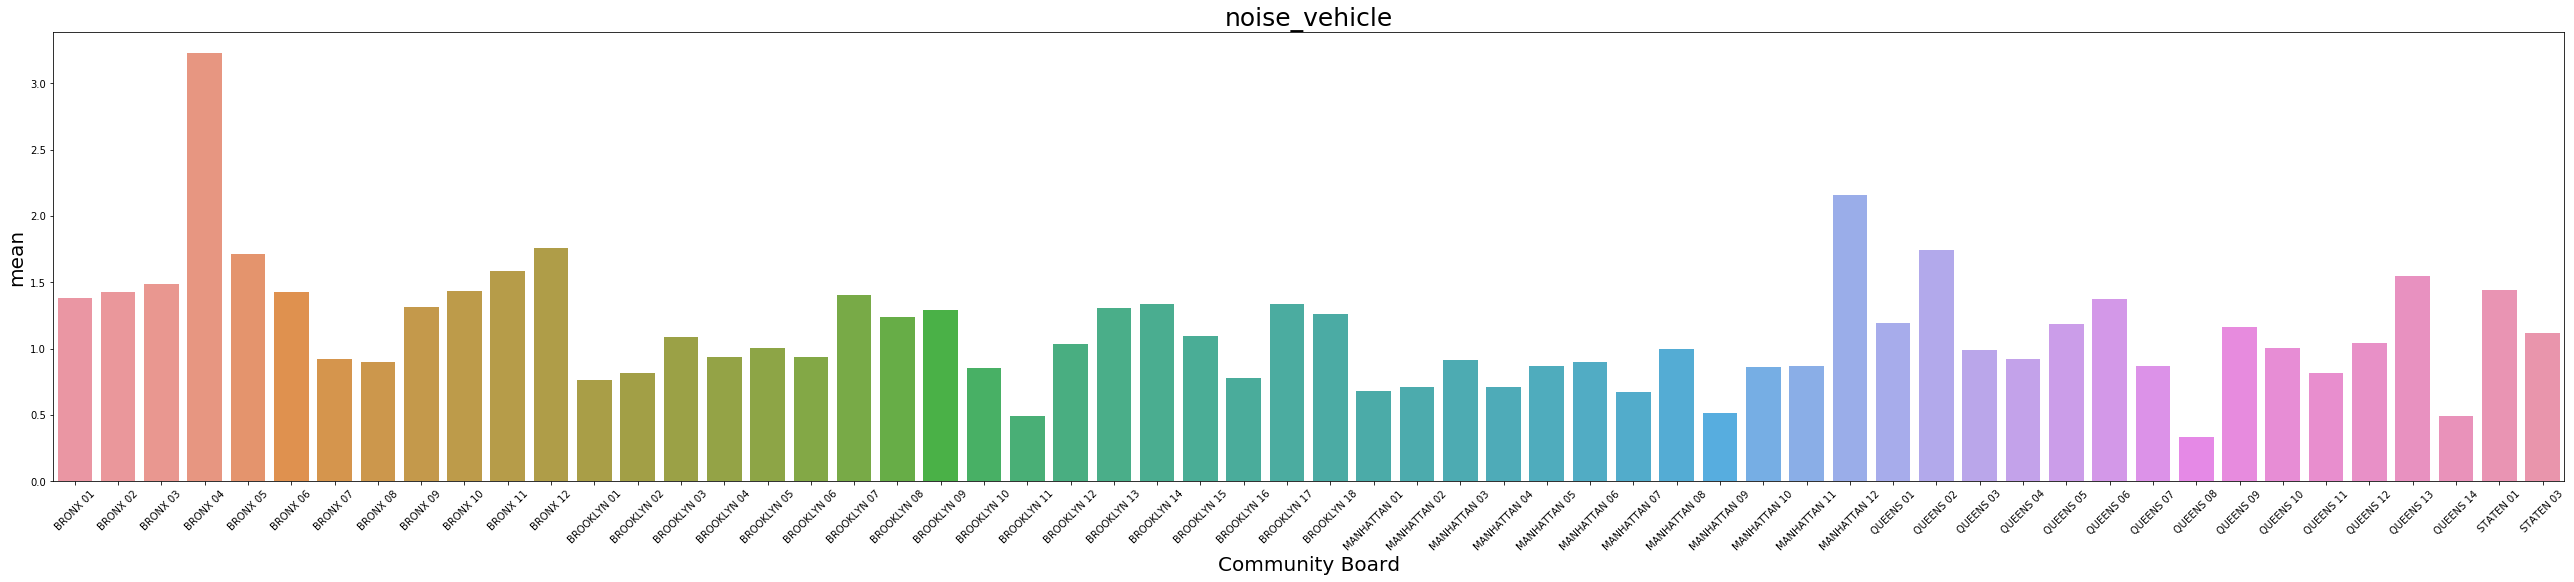

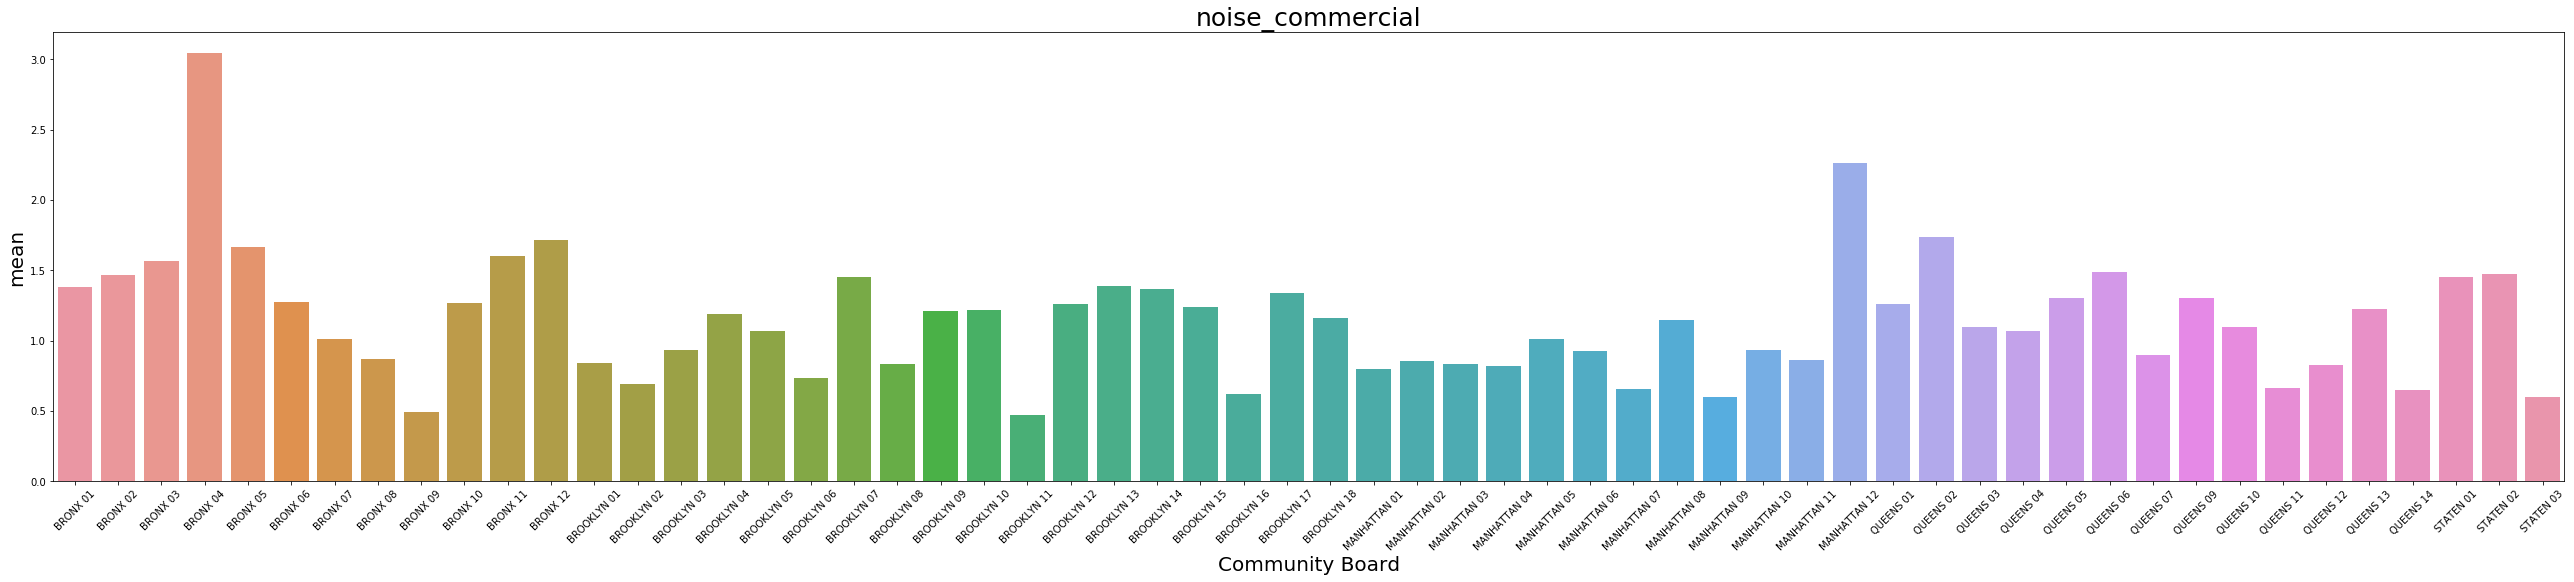

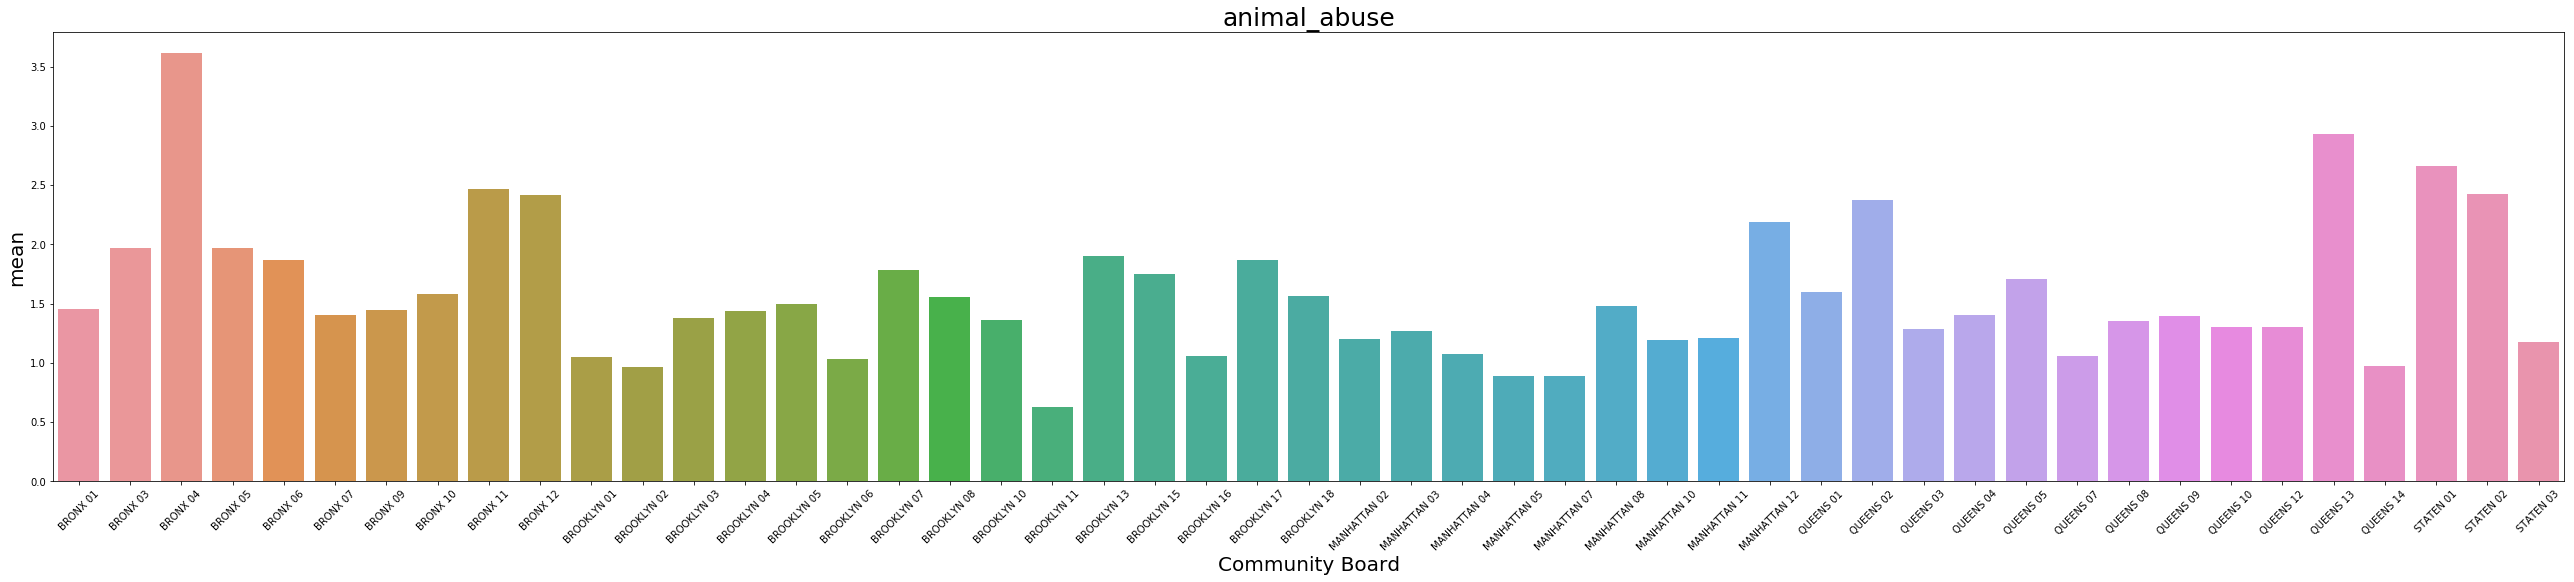

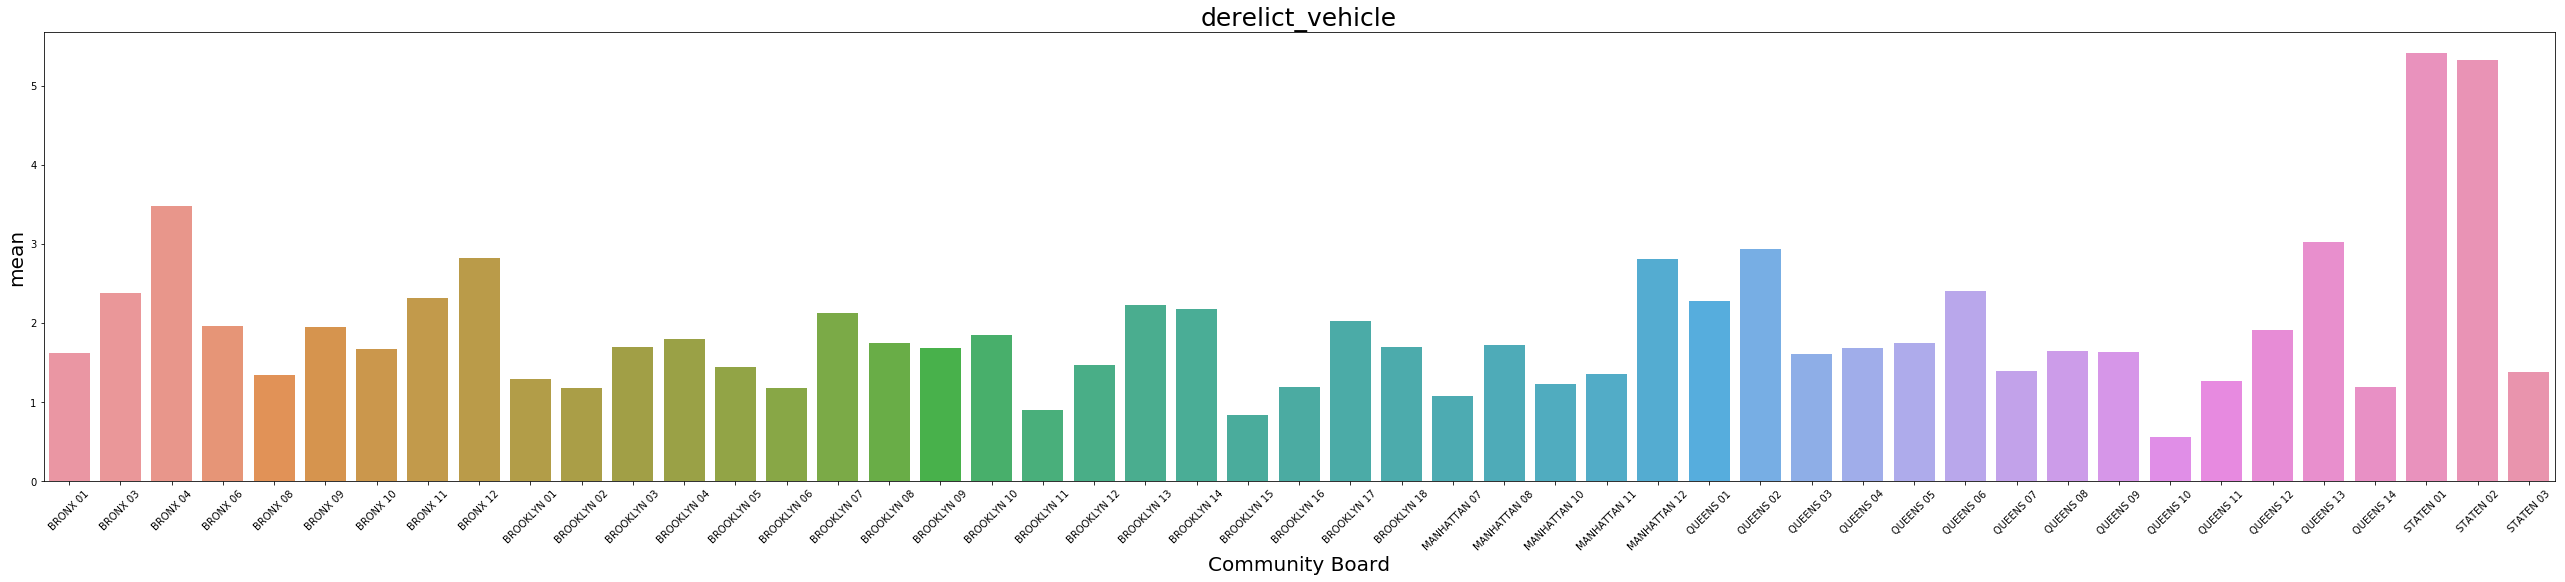

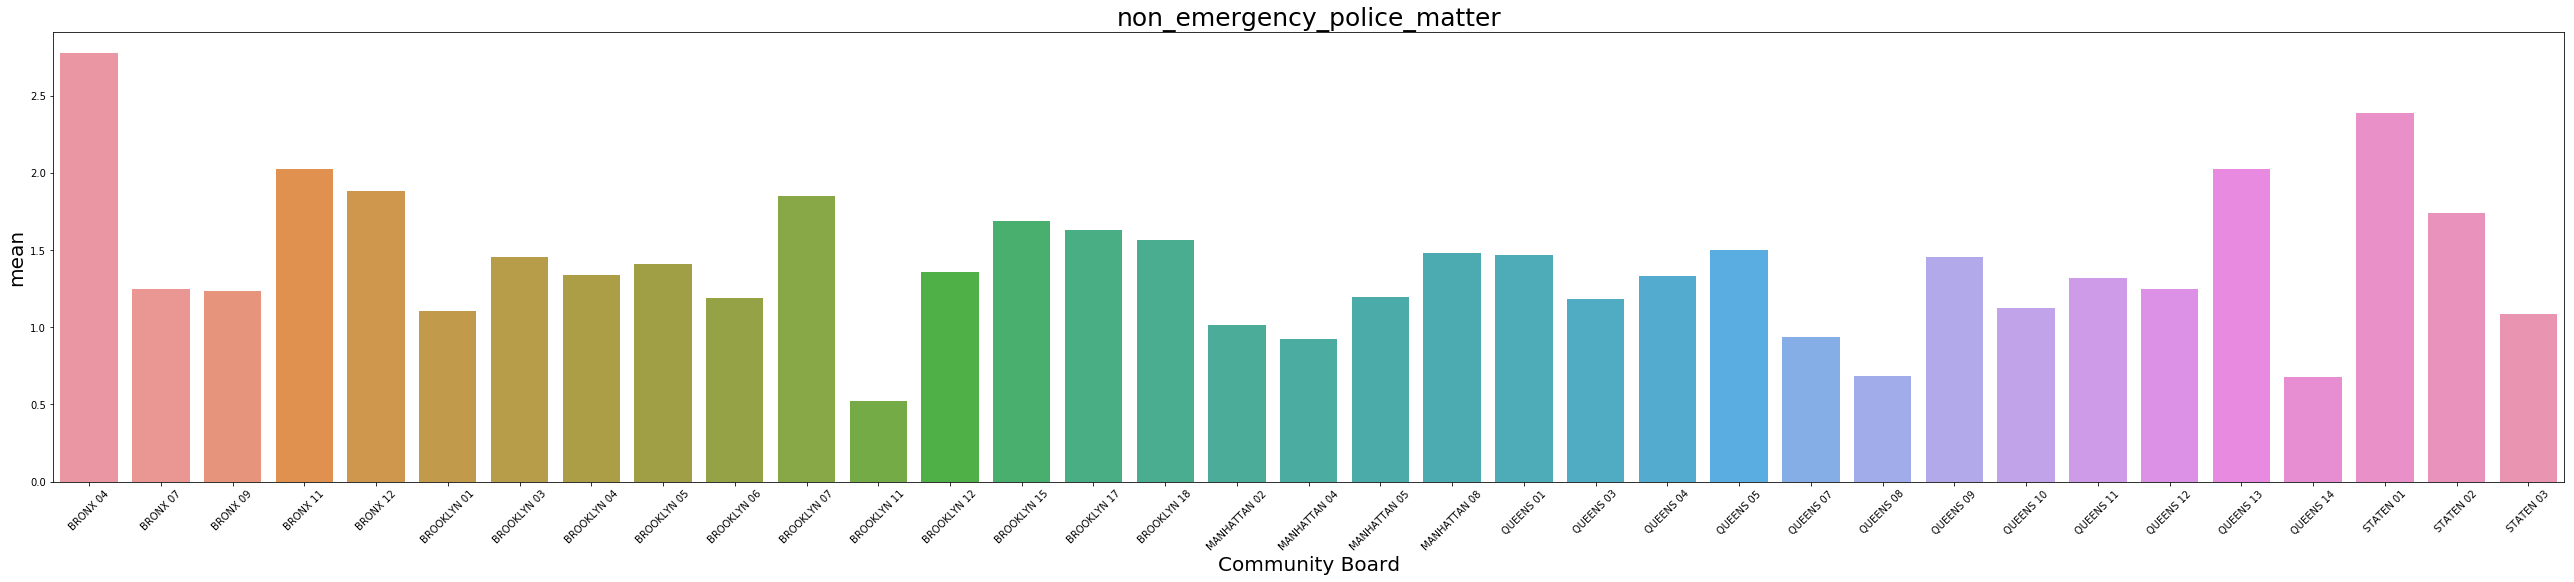

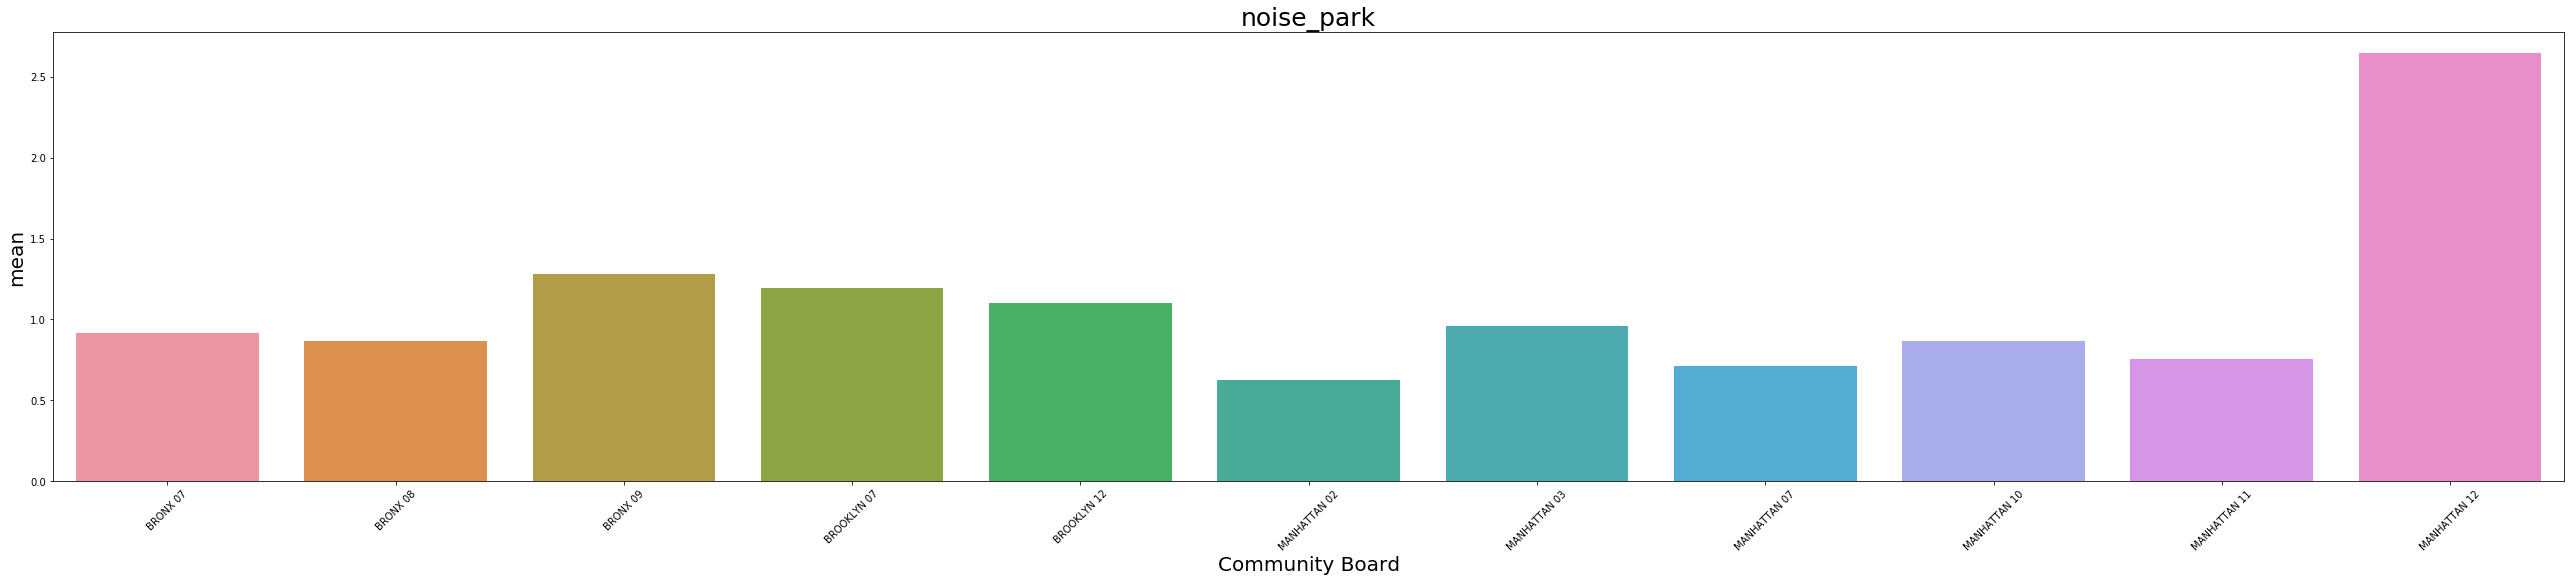

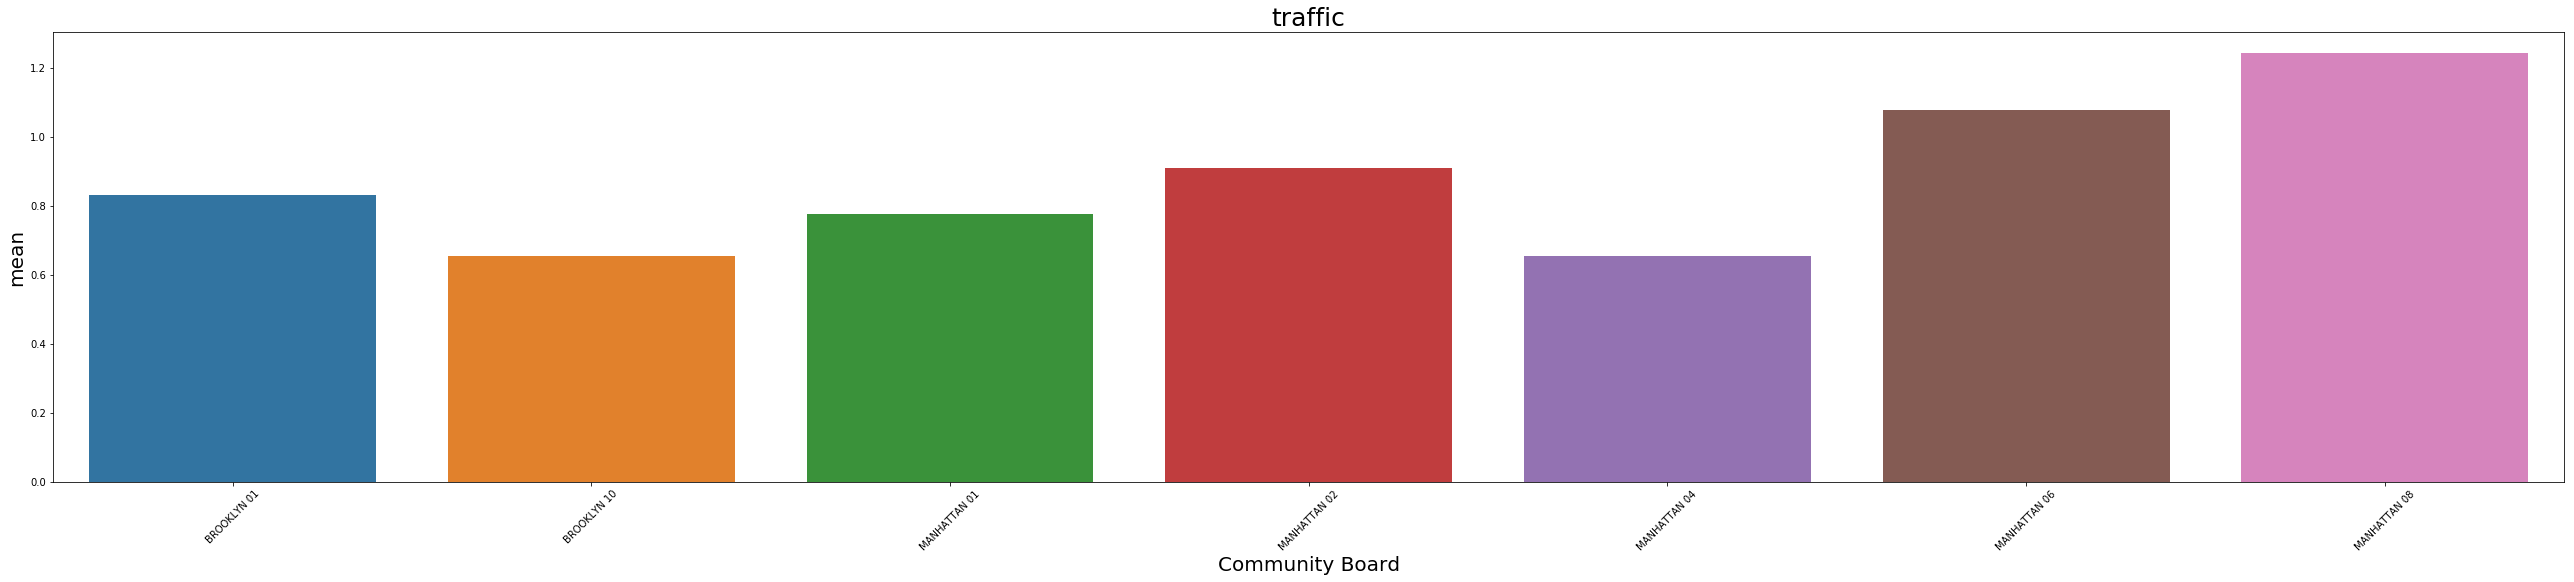

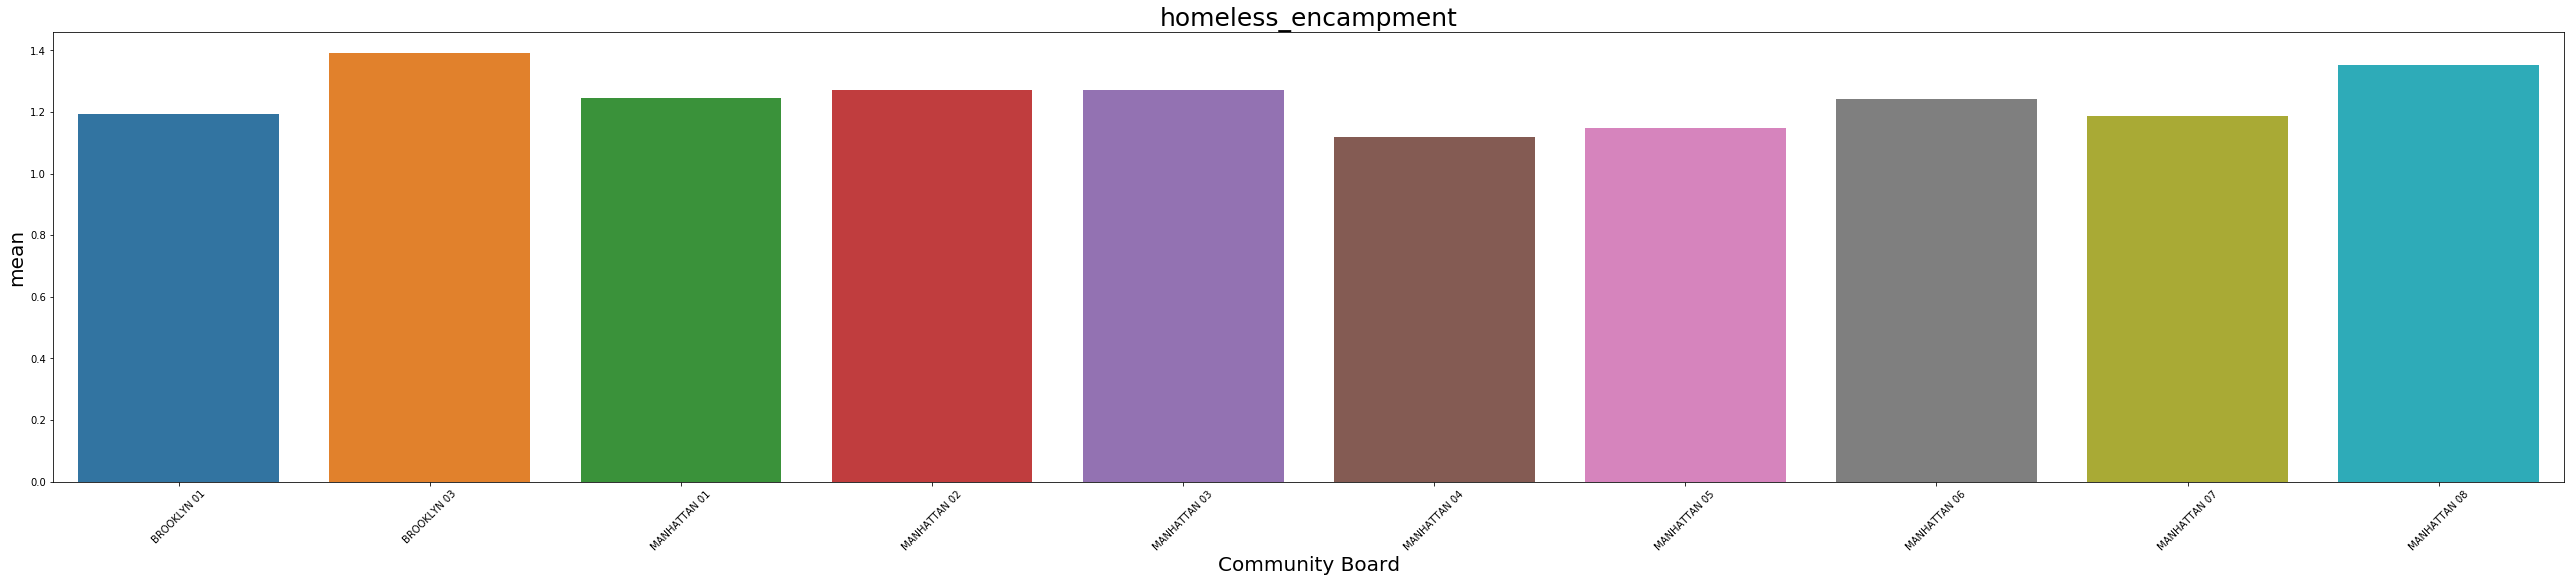

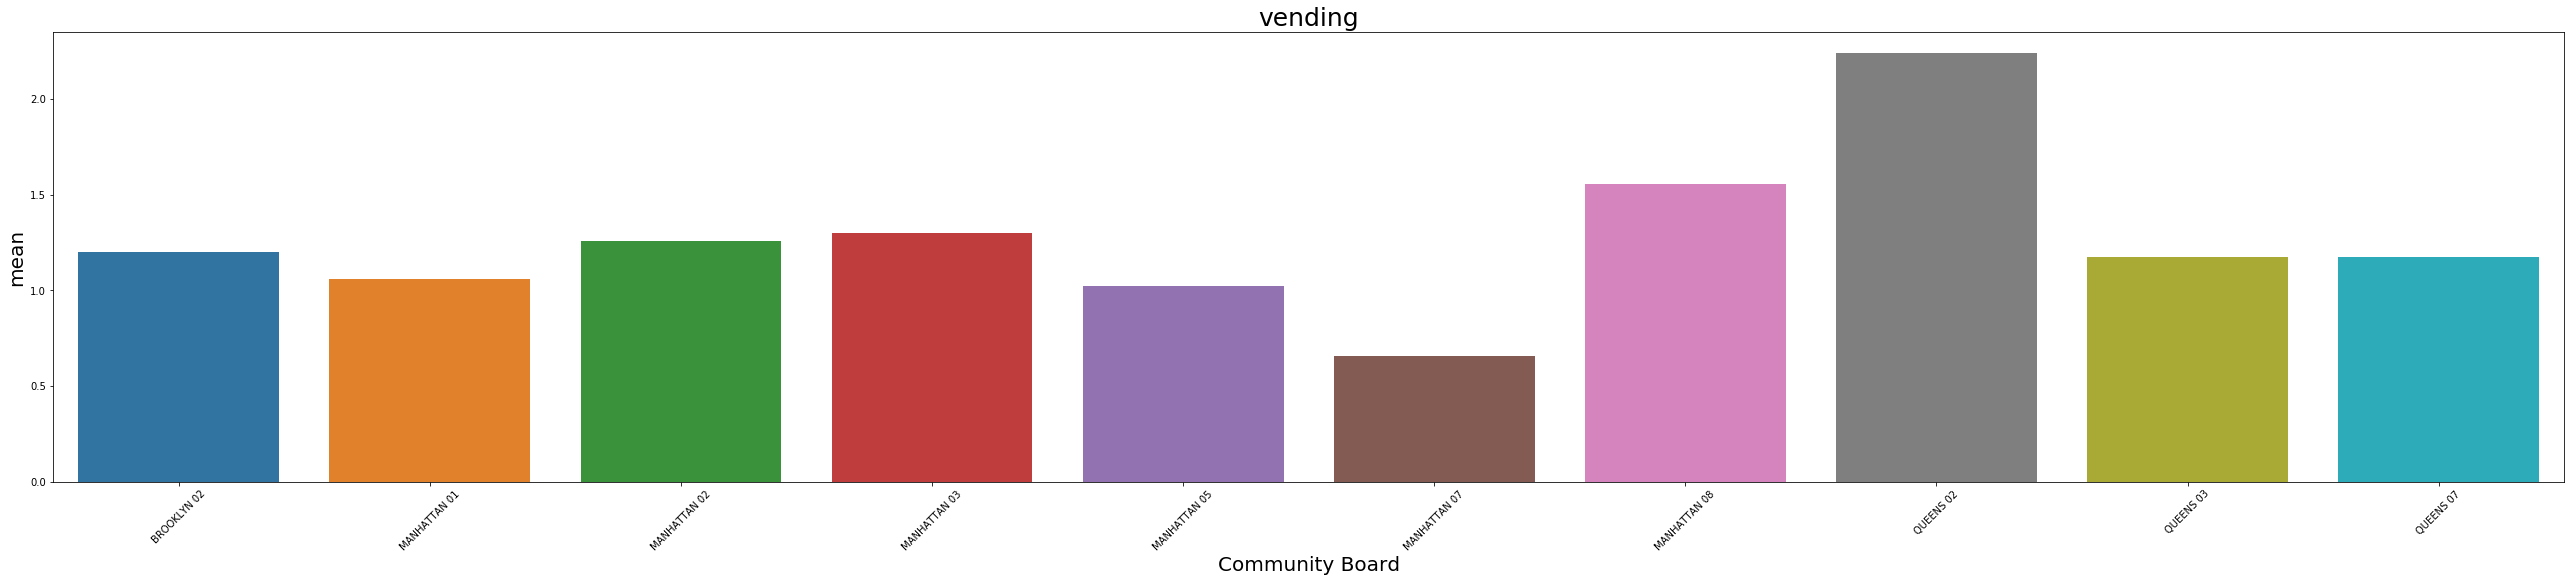

In [29]:
#visually breaks down agency performance by board - log
x= 'Community Board'
y= 'mean'
a4_dims = (45, 8.27)




for i in range(len(nypd_complaint_list)):
    fig, ax = plt.subplots(figsize=a4_dims)
    ax.set_title(nypd_complaint_list[i], fontsize=25)
    ax.set_xlabel("Community Board",fontsize=20)
    ax.set_ylabel("Log Mean Completion Time",fontsize=20)
    agencyboardplot = sns.barplot(x, y, data=nypd_complaints[i], ax=ax)
    agencyboardplot.set_xticklabels(agencyboardplot.get_xticklabels(), rotation=45)

/home/ben/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


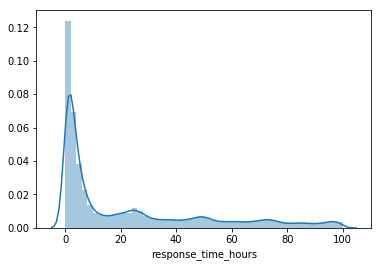

In [30]:
#visualize distribution of complaints resolved between 0 and 100 hours
sns.distplot(db[(db.response_time_hours>0) & (db.response_time_hours<100)].response_time_hours)

In [31]:
#analyzing complaints that took more than 100 hours to solve

hundo = db[db.response_time_hours>100]

In [32]:
agency_list = ['NYPD','HPD','DOT','DOF','DSNY','DEP','DPR','DOB','DOF','DOHMH','DHS','TLC']


hundo['Complaint Type'].value_counts()

hundo_grouped = hundo.groupby(['Agency','Complaint Type'])
hundo_grouped = hundo_grouped.response_time_hours.agg(['mean', 'median', 'std', 'count']).sort_values(by = ['Agency', 'mean'], ascending = False)
hundo_grouped = hundo_grouped[hundo_grouped['count'] >200]
hundo_grouped = hundo_grouped.reset_index()
hundo_grouped = hundo_grouped.query('Agency in @agency_list')

In [33]:
nypd_hundo = hundo_grouped[hundo_grouped['Agency']=='NYPD'].sort_values(by='Complaint Type')
hpd_hundo = hundo_grouped[hundo_grouped['Agency']=='HPD'].sort_values(by='Complaint Type')
dot_hundo = hundo_grouped[hundo_grouped['Agency']=='DOT'].sort_values(by='Complaint Type')
dsny_hundo = hundo_grouped[hundo_grouped['Agency']=='DSNY'].sort_values(by='Complaint Type')
dep_hundo = hundo_grouped[hundo_grouped['Agency']=='DEP'].sort_values(by='Complaint Type')
dpr_hundo = hundo_grouped[hundo_grouped['Agency']=='DPR'].sort_values(by='Complaint Type')
dob_hundo = hundo_grouped[hundo_grouped['Agency']=='DOB'].sort_values(by='Complaint Type')
dof_hundo = hundo_grouped[hundo_grouped['Agency']=='DOF'].sort_values(by='Complaint Type')
dohmh_hundo = hundo_grouped[hundo_grouped['Agency']=='DOHMH'].sort_values(by='Complaint Type')
tlc_hundo = hundo_grouped[hundo_grouped['Agency']=='TLC'].sort_values(by='Complaint Type')

agency_list = [nypd_hundo,hpd_hundo,dot_hundo,dsny_hundo,dep_hundo,dpr_hundo,dob_hundo,dof_hundo,dohmh_hundo,tlc_hundo]

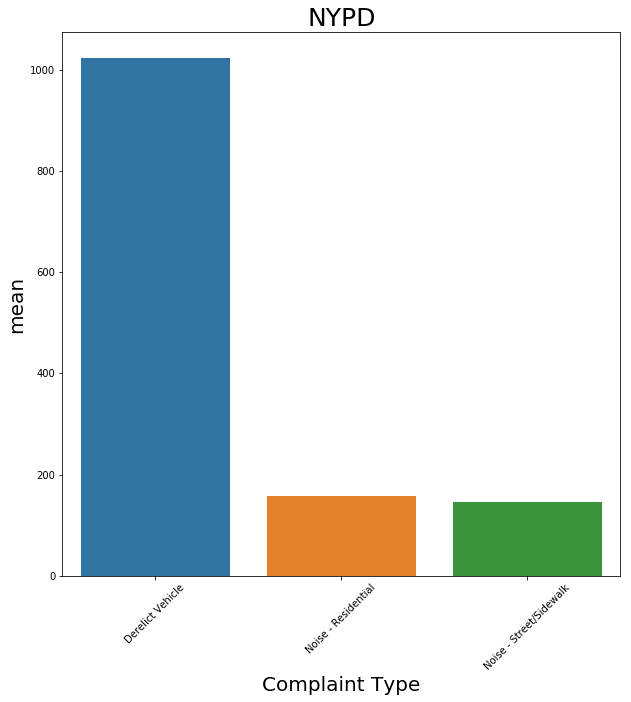

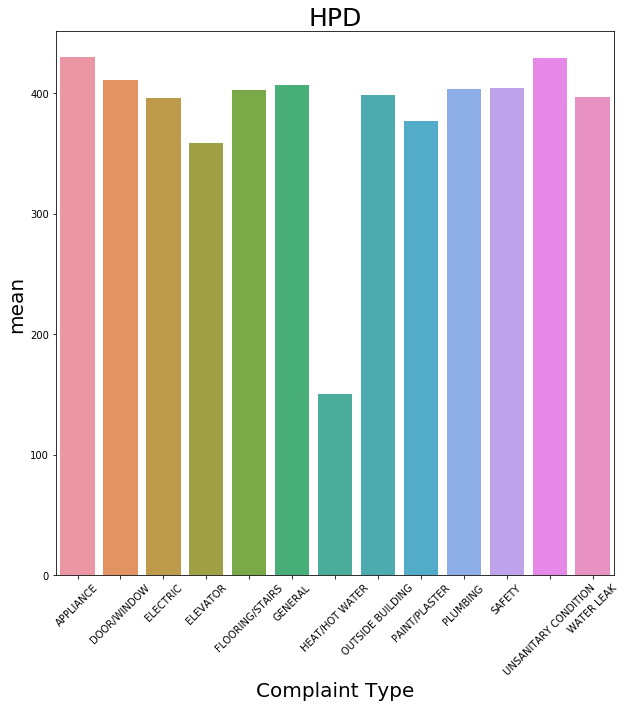

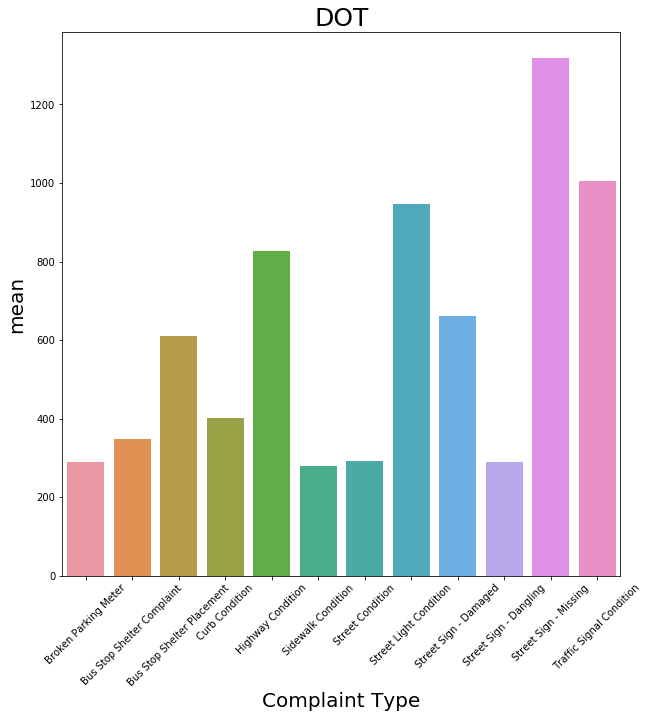

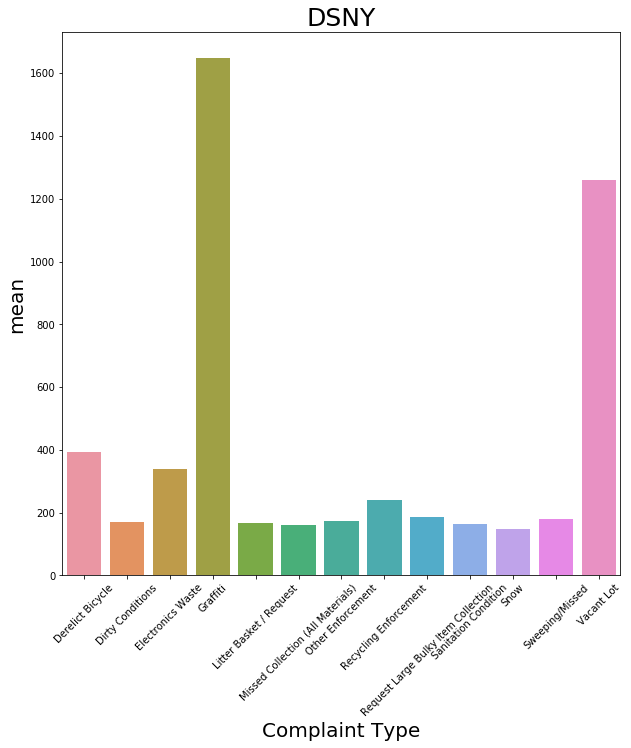

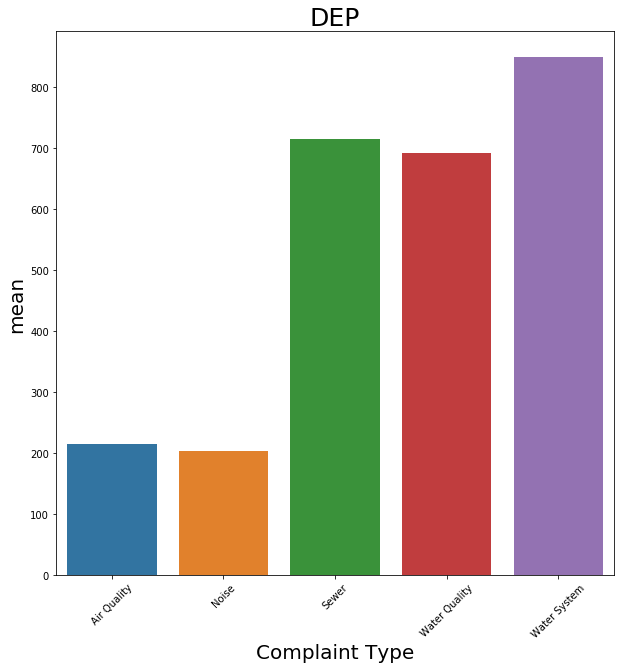

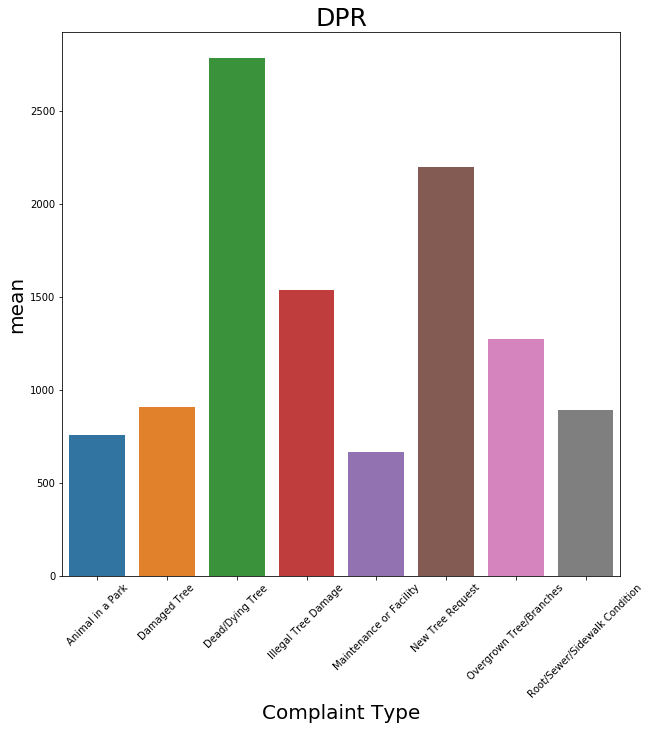

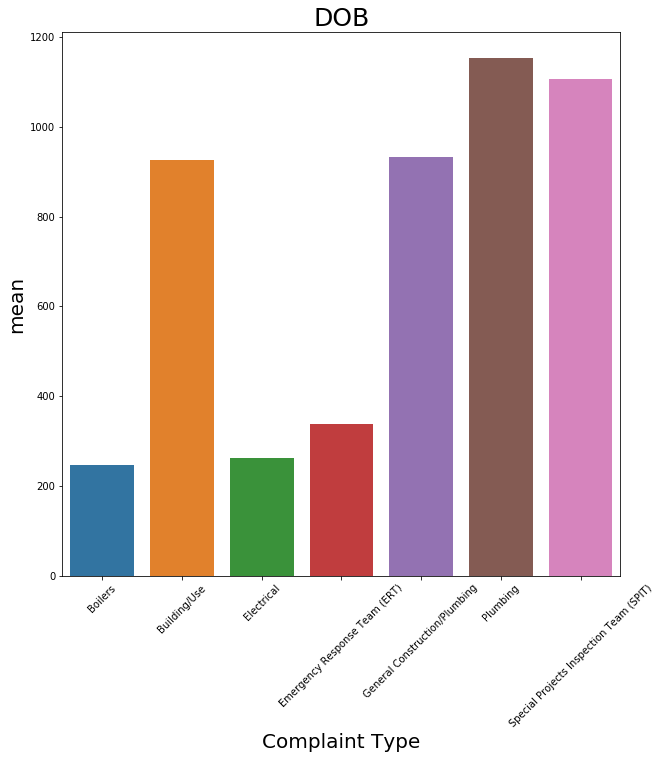

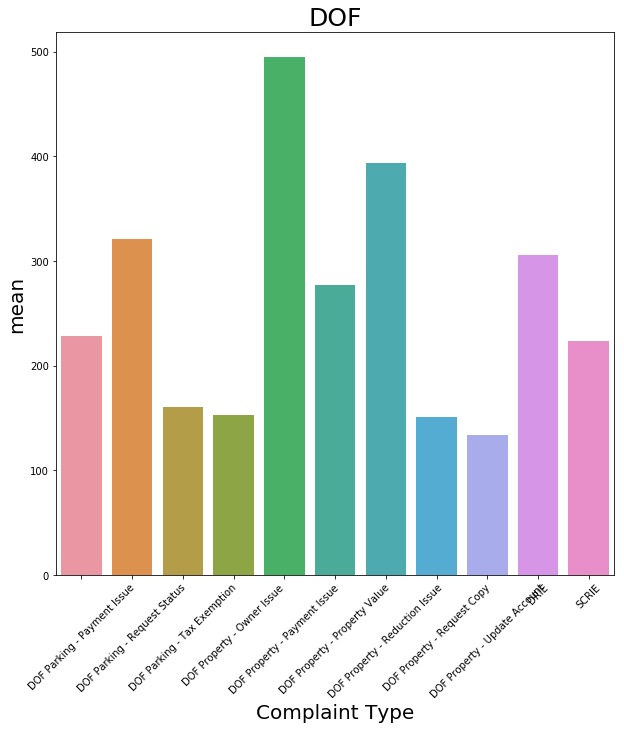

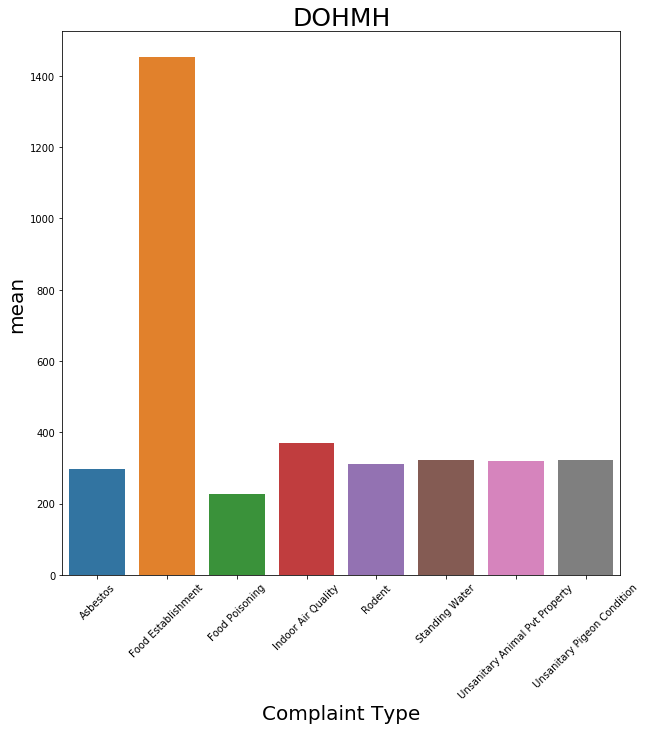

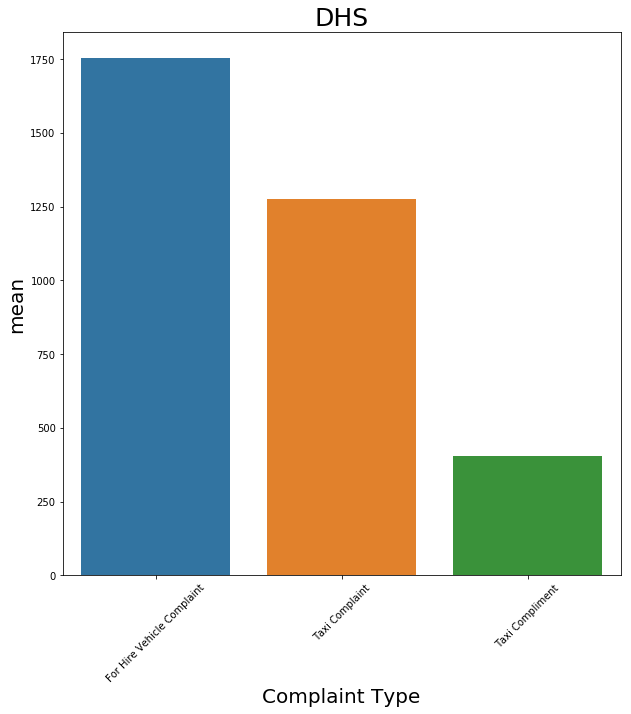

In [34]:
#visually breaks down complaints that take more than 100 hours to resolve by agency
x= 'Complaint Type'
y= 'mean'
a4_dims = (10, 10)

for i in range(len(agency_list)):
    fig, ax = plt.subplots(figsize=a4_dims)
    ax.set_title(agency_name_list[i], fontsize=25)
    ax.set_xlabel("Complaint Type",fontsize=20)
    ax.set_ylabel("Mean Completion Time",fontsize=20)
    hundoboardplot = sns.barplot(x, y, data=agency_list[i], ax=ax)
    hundoboardplot.set_xticklabels(hundoboardplot.get_xticklabels(), rotation=45)


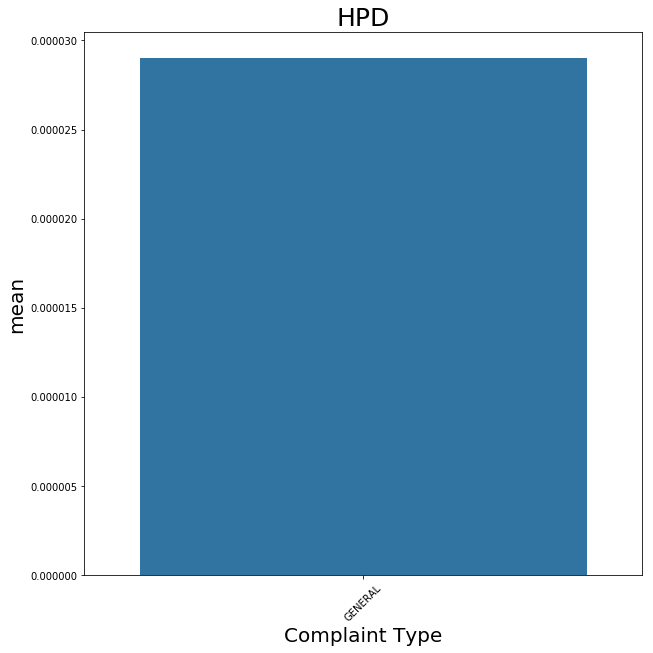

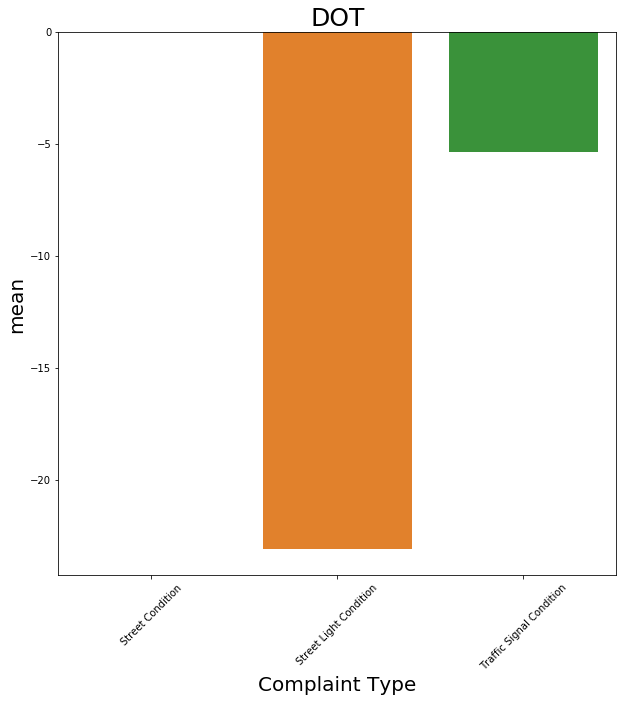

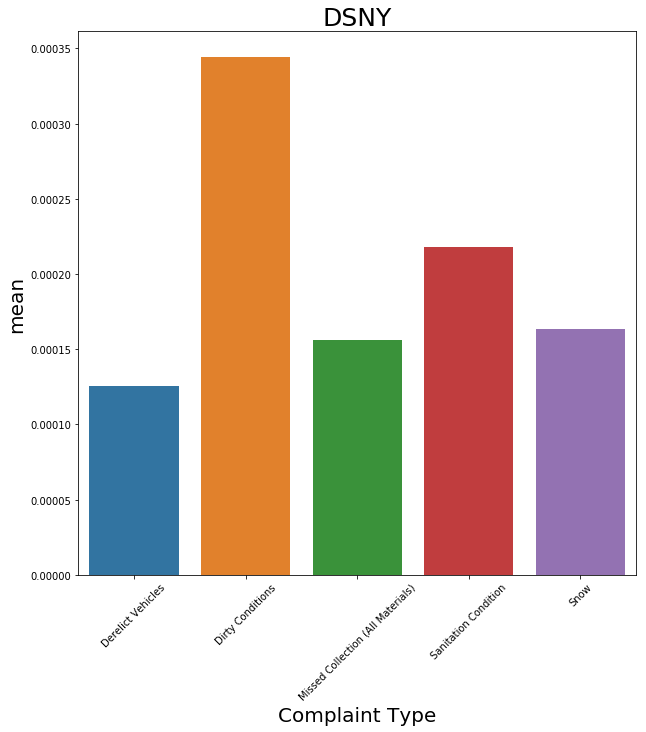

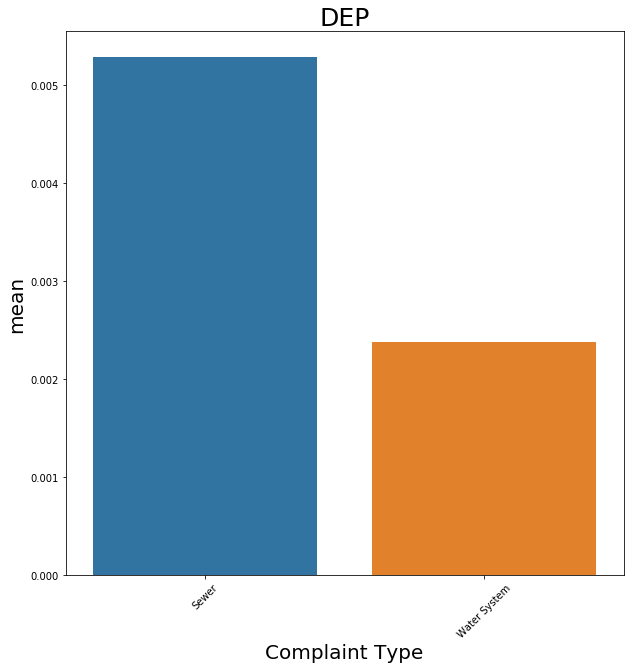

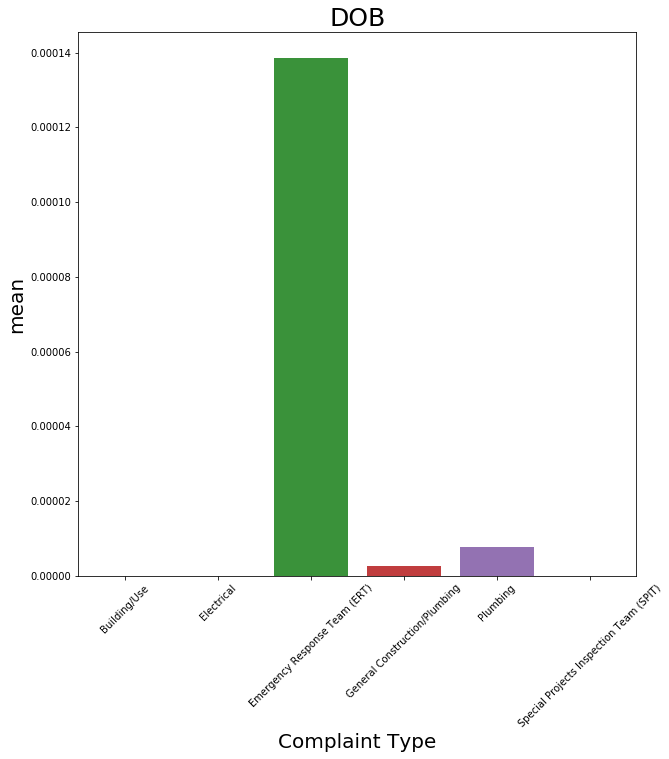

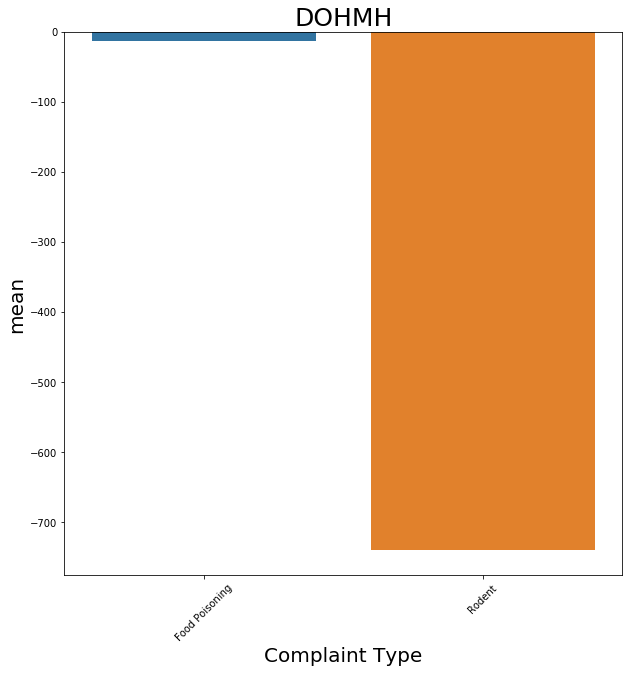

In [38]:
# analyze complaints resolved in under 120 seconds

under2 = db[db.under_120 == 1]

under2_grouped = under2.groupby(['Agency','Complaint Type'])
under2_grouped = under2_grouped.response_time_hours.agg(['mean', 'median', 'std', 'count']).sort_values(by = ['Agency', 'mean'], ascending = False)
under2_grouped = under2_grouped[under2_grouped['count'] >200]
under2_grouped = under2_grouped.reset_index()



hpd_under2 = under2_grouped[under2_grouped['Agency']=='HPD'].sort_values(by='Complaint Type')
dot_under2 = under2_grouped[under2_grouped['Agency']=='DOT'].sort_values(by='Complaint Type')
dsny_under2 = under2_grouped[under2_grouped['Agency']=='DSNY'].sort_values(by='Complaint Type')
dep_under2 = under2_grouped[under2_grouped['Agency']=='DEP'].sort_values(by='Complaint Type')
dob_under2 = under2_grouped[under2_grouped['Agency']=='DOB'].sort_values(by='Complaint Type')
dohmh_under2 = under2_grouped[under2_grouped['Agency']=='DOHMH'].sort_values(by='Complaint Type')
tlc_under2 = under2_grouped[under2_grouped['Agency']=='TLC'].sort_values(by='Complaint Type')

under_agency_name_list = ['HPD','DOT','DSNY','DEP','DOB','DOHMH']


under_agency_list = [hpd_under2,dot_under2,dsny_under2,dep_under2,dob_under2,dohmh_under2]

#visually breaks down agency performance by board
x= 'Complaint Type'
y= 'mean'
a4_dims = (10, 10)

for i in range(len(under_agency_name_list)):
    fig, ax = plt.subplots(figsize=a4_dims)
    ax.set_title(under_agency_name_list[i], fontsize=25)
    ax.set_xlabel("Complaint Type",fontsize=20)
    ax.set_ylabel("Mean Completion Time",fontsize=20)
    underbarplots = sns.barplot(x, y, data=under_agency_list[i], ax=ax)
    underbarplots.set_xticklabels(underbarplots.get_xticklabels(), rotation=45)

In [40]:
#A look at all complaint types with at least 200 complaints

db_grouped = db.groupby(['Agency', 'Complaint Type'])
db_grouped = db_grouped.response_time_hours.agg(
    ['mean','median','std','count', 'min', 'max']
).sort_values(by = ['Agency', 'std'],ascending=False)
db_grouped = db_grouped[db_grouped['count']>200]

In [41]:
db_as_df = db_grouped.reset_index()

In [42]:
# determining complaint types' percentage of total

complaint_types = list(db['Complaint Type'].unique())


complaint_values = []
for i in range(len(complaint_types)):
    x = round(len(db[db['Complaint Type']==complaint_types[i]])/len(db),2)
    complaint_values.append(x)
    
#results in scalar, makes making a dataframe more difficult    
#complaint_rates = dict(zip(complaint_types, complaint_values))
complaint_rates_as_df =  pd.DataFrame(
    {'Complaint': complaint_types,
     'Percentage': complaint_values
    })
    

In [43]:
complaint_rates_as_df = complaint_rates_as_df.sort_values(by='Percentage', ascending=False).reset_index()

In [44]:
#grab the top 50 complaints by percentage of total complaints
top_complaints = list(complaint_rates_as_df['Complaint'][:50])

In [45]:
#grab the response times associated with top 50 most common complaints

complaint_times = [list([]) for _ in range(len(top_complaints))]

for i in range(len(top_complaints)):
    complaint_times[i].append(
        np.array(db[db['Complaint Type']==top_complaints[i]]['response_time_hours']))
    complaint_times[i] = complaint_times[i][0]
    


In [46]:
#remove nulls
def no_nulls(nested_list):
    for lst in range(len(nested_list)):
        nested_list[i] = [x for x in nested_list[i] if x==x]
    return nested_list

complaint_times = no_nulls(complaint_times)

In [48]:
from scipy.stats import iqr
from scipy.stats import zscore

#get z-scores for complaint times
def get_zscores(lst):
    zscore_lst = []
    for i in range(len(lst)):
        zscore_lst.append(zscore(lst[i]))
    return zscore_lst

zscores = get_zscores(complaint_times)
zscores_lists = [array.tolist() for array in zscores]
zscore_flat_list = [item for sublist in zscores_lists for item in sublist]


In [49]:
#create dataframe with zscores and iqr of zscores 

dist_df = pd.DataFrame({'Type': top_complaints, 'Times': complaint_times, 'ZScores': zscores})

iqr_zscores = [iqr(i) for i in zscores]
        
dist_df['iqr_zscore'] = iqr_zscores

In [54]:
# create a new dataframe combining all instances of a complaint type's appearance, the iqr_zscore for the complaint
#type, the time for that individual complaint, and the zscore for the individual complaint
dist_df_spread  = dist_df
Time = dist_df_spread.apply(lambda x: pd.Series(x['Times']),axis=1).stack().reset_index(level=1, drop=True)
Time.name = 'Time'
dist_df_spread = dist_df_spread.drop(['Times', 'ZScores'], axis=1).join(Time)

dist_df_spread['zscore'] = zscore_flat_list
dist_df_spread

,Type,iqr_zscore,Time,zscore
0,HEAT/HOT WATER,1.087012,129.523889,1.117191
0,HEAT/HOT WATER,1.087012,163.867222,1.745796
0,HEAT/HOT WATER,1.087012,68.533056,0.000843
0,HEAT/HOT WATER,1.087012,140.558611,1.319166
0,HEAT/HOT WATER,1.087012,187.249444,2.173774
0,HEAT/HOT WATER,1.087012,19.608611,-0.894648
0,HEAT/HOT WATER,1.087012,154.041111,1.565943
0,HEAT/HOT WATER,1.087012,187.215278,2.173148
0,HEAT/HOT WATER,1.087012,230.809167,2.971071
0,HEAT/HOT WATER,1.087012,130.016944,1.126216


In [ ]:
#export for visual analysis in R (see R script in repo)

dist_df_spread.to_csv('complaint_zscore_spread.csv')

/home/ben/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


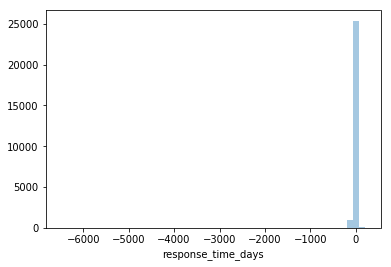

In [57]:
#quick visual of rodent response times
sns.distplot(db[db['Complaint Type']=='Rodent']['response_time_days'], kde=False)

In [58]:
#analyze lead complaint resolutions
lead = db[db['Complaint Type']=='Lead']
lead['Resolution Description'].value_counts()

the department of environmental protection investigated this complaint and created a service request to have a lead test kit sent to the complainant.                                                                                                                                  3197
the department of environment protection inspected your complaint but could not find the problem you reported. if the condition persists, please call 311 (or 212-639-9675 if calling from a non-new york city area code) with more detailed information to submit a new complaint.       2
the department of environmental protection determined that an inspection is not warranted to investigate this complaint at this time and sent a letter to the complainant and/or respondent.                                                                                              1
the department of environmental protection investigated this complaint and found there was no sewer back up in the city system at the time of the in

/home/ben/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


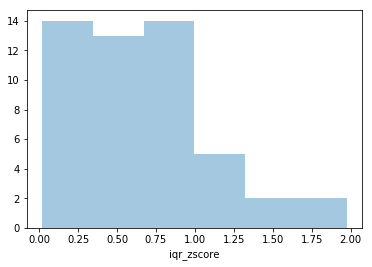

In [59]:
#plot iqrs of zscores
sns.distplot(dist_df['iqr_zscore'], kde=False)

In [62]:
print('iqr of iqrs: ', iqr(dist_df.iqr_zscore), '\n'
      'mean of iqrs: ', dist_df.iqr_zscore.mean(), '\n'
      'max: ', dist_df.iqr_zscore.max(), '\n'
      'min: ', dist_df.iqr_zscore.min())


iqr of iqrs:  0.6247550918969069 
mean of iqrs:  0.6592757620801268 
max:  1.9727987126859883 
min:  0.019924128655333745


/home/ben/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


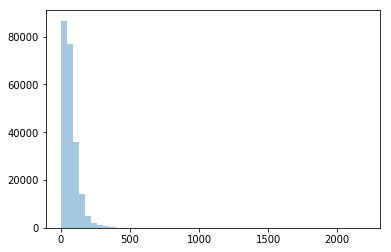

In [63]:
sns.distplot(dist_df['Times'][0], kde=False)

1.087012169974542


/home/ben/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


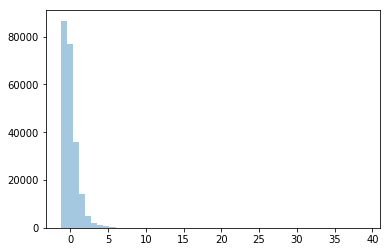

In [64]:
print(dist_df.iqr_zscore[0])
sns.distplot(dist_df.ZScores[0], kde=False)

In [67]:
#determine how many duplicate cases for consumer complaints with response time less than 5 days

db[(db['Complaint Type']=='Consumer Complaint')&(db['response_time_days']<5)].res_desc.value_counts()


duplicate          3535
wrong_agency       3185
string              460
ongoing             347
no_action_taken     332
ambiguous            48
Name: res_desc, dtype: int64

In [68]:
#seeing duplicates as a percentage of all "consumer complaint" complaints addressed in under 5 days
3535/len(db[(db['Complaint Type']=='Consumer Complaint')&(db['response_time_days']<5)])

0.4470722144934868

In [69]:
db[(db['Complaint Type']=='Consumer Complaint')&(db['response_time_hours']<200)].res_desc.value_counts()

duplicate          3552
wrong_agency       3191
string              462
ongoing             349
no_action_taken     332
ambiguous            48
Name: res_desc, dtype: int64

fixed              2925
did_not_observe    2649
wrong_agency        140
duplicate            16
Name: res_desc, dtype: int64 1 Missed Collection                  1549
1R Missed Recycling-All Materials    1197
2 Bulk-Missed Collection              929
2R Bulk-Missed Recy Collection        549
1RG Missed Recycling Paper            475
1RB Missed Recycling - M/G/Pl         464
1RO Missed Recycling Organics         457
1L Missed Recycling Leaves             94
1C Uncollected Xmas Trees              16
Name: Descriptor, dtype: int64 01 STATEN ISLAND        948
07 QUEENS               938
01 BROOKLYN             476
02 STATEN ISLAND        358
12 QUEENS               322
06 BROOKLYN             302
03 STATEN ISLAND        297
18 BROOKLYN             282
13 QUEENS               177
10 BROOKLYN             174
12 BROOKLYN             151
14 QUEENS               134
08 QUEENS               102
17 BROOKLYN              94
15 BROOKLYN              77
11 BROOKLYN              70
10 MANHATTAN      

/home/ben/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


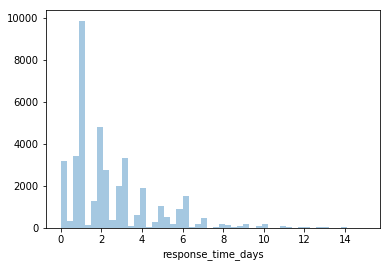

In [70]:
#a summary of results related to the complaint "missed collection (all materials)"
print(db[(db['Complaint Type']=='Missed Collection (All Materials)')&(db['response_time_days']>5)].res_desc.value_counts(),
      db[(db['Complaint Type']=='Missed Collection (All Materials)')&(db['response_time_days']>5)].Descriptor.value_counts(),
      db[(db['Complaint Type']=='Missed Collection (All Materials)')&(db['response_time_days']>5)]['Community Board'].value_counts(),
      db[(db['Complaint Type']=='Missed Collection (All Materials)')&(db['response_time_days']<5)].res_desc.value_counts(),
      db[(db['Complaint Type']=='Missed Collection (All Materials)')&(db['response_time_days']<5)].Descriptor.value_counts(),
      db[(db['Complaint Type']=='Missed Collection (All Materials)')&(db['response_time_days']<5)]['Community Board'].value_counts())
sns.distplot(db[
    (db['Complaint Type']=='Missed Collection (All Materials)')&
    (db['response_time_days']<15)].response_time_days, kde=False)

In [71]:
#create missed collection complaint df, aggregate by count
missed_collection = db[db['Complaint Type']=='Missed Collection (All Materials)']
missed_collection['five_and_up'] = missed_collection.response_time_days >=5
missed_collection_grouped  = missed_collection.groupby(['Community Board', 'five_and_up'])
missed_collection_grouped = missed_collection_grouped.response_time_days.aggregate('count').to_frame().reset_index()
missed_collection_grouped = missed_collection_grouped[missed_collection_grouped.five_and_up == True]


missed_collection_grouped_2 = missed_collection.groupby('Community Board')
missed_collection_grouped_2 = missed_collection_grouped_2.response_time_days.aggregate('count').to_frame().reset_index()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [72]:
#group and sort for missed collection complaint
     
missed_collection_grouped = missed_collection_grouped.sort_values('Community Board')
missed_collection_grouped_2 = missed_collection_grouped_2.sort_values('Community Board')

<class 'numpy.bool_'> <class 'numpy.int64'>


In [73]:
#join the frames to show the total number of missed collection complaints by community board, 
#number of complaints that took more than 5 days, and that  percent of total

missed_collection_total = missed_collection_grouped.join(missed_collection_grouped_2.set_index("Community Board"), on='Community Board', lsuffix = '_l', rsuffix = '_r')
missed_collection_total = missed_collection_total.rename(columns = {'response_time_days_l': 'count_over_5', 'response_time_days_r': 'total'})
missed_collection_total = missed_collection_total.drop(['five_and_up'], axis=1)
missed_collection_total['five_up_rate'] = round(missed_collection_total.count_over_5/missed_collection_total.total,2)
missed_collection_total.sort_values(by = ['five_up_rate', 'count_over_5'])



,Community Board,count_over_5,total,five_up_rate
36,04 QUEENS,1,248,0.00
92,12 BRONX,3,641,0.00
30,04 BRONX,1,86,0.01
65,08 MANHATTAN,2,266,0.01
34,04 MANHATTAN,4,519,0.01
55,07 BROOKLYN,5,513,0.01
73,09 MANHATTAN,1,63,0.02
100,13 BROOKLYN,3,152,0.02
77,10 BRONX,14,800,0.02
22,03 BROOKLYN,22,989,0.02


fixed              496
ambiguous           19
wrong_agency         2
no_action_taken      2
Name: res_desc, dtype: int64 No Parking, Standing, Stopping    235
Street Cleaning - ASP             150
Other/Unknown                     119
Speed Limit                         8
Stop                                3
School Crossing                     1
Construction                        1
Do Not Enter                        1
One Way                             1
Name: Descriptor, dtype: int64 02 BROOKLYN         49
17 BROOKLYN         47
01 BROOKLYN         37
12 BROOKLYN         34
11 BROOKLYN         28
13 BROOKLYN         27
05 BROOKLYN         23
18 BROOKLYN         21
14 QUEENS           17
15 BROOKLYN         17
16 BROOKLYN         17
06 BROOKLYN         16
07 BROOKLYN         15
04 BROOKLYN         15
07 QUEENS           13
14 BROOKLYN         13
03 BROOKLYN         12
01 QUEENS           10
0 Unspecified       10
05 QUEENS            9
09 BROOKLYN          9
09 QUEENS            7


AttributeError: 'tuple' object has no attribute 'set'

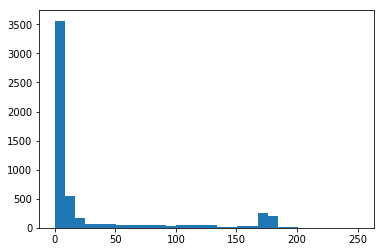

In [74]:
#summary of data on missing street signs

print(db[(db['Complaint Type']=='Street Sign - Missing')&(db['response_time_days']>160)].res_desc.value_counts(),
db[(db['Complaint Type']=='Street Sign - Missing')&(db['response_time_days']>160)].Descriptor.value_counts(),
db[(db['Complaint Type']=='Street Sign - Missing')&(db['response_time_days']>160)]['Community Board'].value_counts(),
db[(db['Complaint Type']=='Street Sign - Missing')&(db['response_time_days']<160)].res_desc.value_counts(),
db[(db['Complaint Type']=='Street Sign - Missing')&(db['response_time_days']<160)].Descriptor.value_counts(),
db[(db['Complaint Type']=='Street Sign - Missing')&(db['response_time_days']<160)]['Community Board'].value_counts())


ax = plt.hist(db[db['Complaint Type']=='Street Sign - Missing'].response_time_days, bins = 30)
ax.set(xlabel='Num Days to Close', ylabel='Num Complaints')
plt.title("Missing Street Signs", fontsize=20)
plt.show()
ax

/home/ben/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


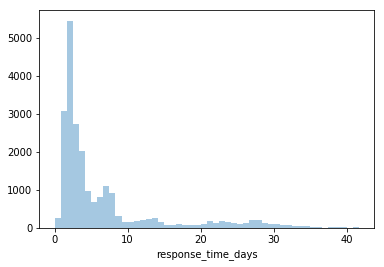

In [77]:
#analyzing electronics waste complaints that took less thanh 1000 hours, represented as days (~ <45)
sns.distplot(db[(db['Complaint Type']=='Electronics Waste')&(db['response_time_hours']<1000)].response_time_days, kde=False)

/home/ben/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


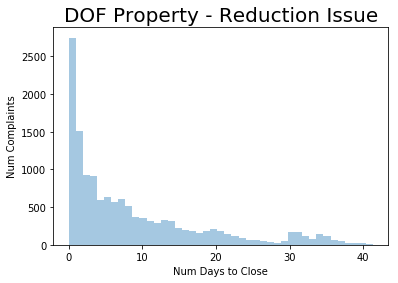

In [78]:
#begin analysis of complaint: 'DOF Property - Reduction Issue'

ax = sns.distplot(
    db[(db['Complaint Type']=='DOF Property - Reduction Issue')&
       (db['response_time_hours']<1000)]['response_time_days'], kde=False)
ax.set(xlabel='Num Days to Close', ylabel='Num Complaints')
plt.title("DOF Property - Reduction Issue", fontsize=20)
plt.show()



In [79]:
# 'DOF Property - Reduction Issue' resolution summary
print(
    db[(db['Complaint Type']=='DOF Property - Reduction Issue')&
    (db['response_time_hours']<1000)&
    (db['response_time_hours']>700)]['Resolution Description'].value_counts(),
    db[(db['Complaint Type']=='DOF Property - Reduction Issue')&
       (db['response_time_hours']<700)]['Resolution Description'].value_counts())

see notes.                                                                            993
the department of finance determined that you are not eligible for this reduction.     11
the department of finance granted this reduction.                                       5
Name: Resolution Description, dtype: int64 see notes.                                                                                                                                  12749
the department of finance granted this reduction.                                                                                              88
the department of finance determined that you are not eligible for this reduction.                                                             78
the department of finance was unable to resolve the issue as it requires additional information.                                               27
the department of finance did not receive an application for this reduction. they mailed you a blank ap

fixed              1669
no_action_taken     216
did_not_observe     153
wrong_agency         11
Name: res_desc, dtype: int64 Branch or Limb Has Fallen Down    755
Branch Cracked and Will Fall      470
Entire Tree Has Fallen Down       468
Tree Alive - in Poor Condition    179
Tree Leaning/Uprooted             150
Tree Trunk Split                   27
Name: Descriptor, dtype: int64 01 STATEN ISLAND        150
02 STATEN ISLAND        146
03 STATEN ISLAND        141
10 BRONX                 92
12 BROOKLYN              87
11 QUEENS                87
07 QUEENS                87
08 QUEENS                85
13 QUEENS                81
18 BROOKLYN              67
11 BRONX                 65
06 QUEENS                63
05 QUEENS                61
12 QUEENS                55
08 BRONX                 52
01 QUEENS                48
12 BRONX                 46
15 BROOKLYN              45
10 BROOKLYN              42
05 BROOKLYN              36
11 BROOKLYN              35
10 QUEENS                29


/home/ben/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


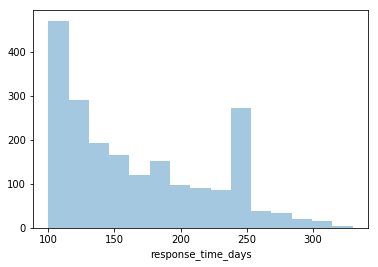

In [80]:
#damaged tree summary

print(db[(db['Complaint Type']=='Damaged Tree')&(db['response_time_days']>100)].res_desc.value_counts(),
      db[(db['Complaint Type']=='Damaged Tree')&(db['response_time_days']>100)].Descriptor.value_counts(),
      db[(db['Complaint Type']=='Damaged Tree')&(db['response_time_days']>100)]['Community Board'].value_counts(),
      db[(db['Complaint Type']=='Damaged Tree')&(db['response_time_days']<100)].res_desc.value_counts(),
      db[(db['Complaint Type']=='Damaged Tree')&(db['response_time_days']<100)].Descriptor.value_counts(),
      db[(db['Complaint Type']=='Damaged Tree')&(db['response_time_days']<100)]['Community Board'].value_counts())
      
sns.distplot(db[(db['Complaint Type']=='Damaged Tree')&(db['response_time_days']>100)].response_time_days, kde=False)

In [83]:
#analyze complaint responses and resolution times regarding rodents

rats = data_orig[data_orig['Complaint Type']=='Rodent']
print(rats['response_time_hours'].median(),
      dist_df_spread[dist_df_spread['Type'] == 'Rodent']['Time'].mean())
rats['response_time_days'] = [i.total_seconds()/86400.0 for i in rats['Response Time']]


#percent of rodent complaints that are solved in negative time
len(rats[rats.response_time_hours<=0])/len(rats)



112.01124999999999 -13.930262319991927


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0.2045998894552601

In [ ]:
rats_grouped = rats.groupby('response_time_days')
rats_grouped = rats_grouped.Agency.aggregate('count')
rats_grouped.to_csv('rat_times.csv')

/home/ben/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


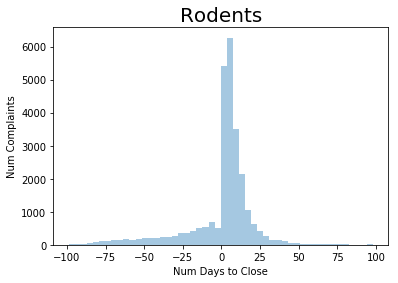

In [82]:
rodents = sns.distplot(rats[(rats.response_time_days>-100)&(rats.response_time_days<100)].response_time_days, kde=False)
rodents.set(xlabel='Num Days to Close', ylabel='Num Complaints')
plt.title("Rodents", fontsize=20)
plt.show()

/home/ben/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


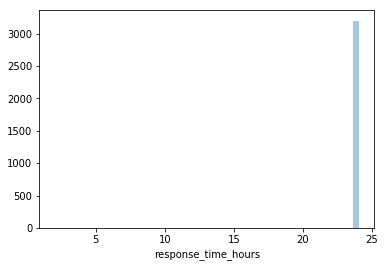

In [84]:
#analyzing led kit responses in less than 30 hours - 
# - it appears an automatic message is sent out exactly 24 hours after the complaint is made
sns.distplot(db[(db['Complaint Type']=='Lead')
               &(db.response_time_hours<30)].response_time_hours, kde=False)

In [85]:
signs = db[db['Complaint Type']=='Street Sign - Missing']
signs_grouped = signs.groupby('response_time_days')
signs_grouped = signs_grouped.Agency.aggregate('count')
signs_grouped.to_csv('signs_times.csv')

In [86]:
db[(db.res_desc == 'ambiguous')&(db.Agency == 'DOT')&(db['Complaint Type']=='Street Light Condition')]['Resolution Description'].value_counts()

service request status for this request is available on the department of transportationâs website. please click the âlearn moreâ link below.    68071
service request status for this request is available on the department of transportation's website. please click the "learn more" link below.           5845
Name: Resolution Description, dtype: int64

In [87]:
#which agencies have the greatest number of ambiguous resolutions?
db[db.res_desc == 'ambiguous'].Agency.value_counts()

DOT      133837
NYPD      40728
DOF       39282
HPD       36504
DOB        3780
DEP        2409
DHS        2260
DCA          48
DOHMH         2
Name: Agency, dtype: int64

In [88]:
#total DOT ambiguous resolutions as a percentage of all DOT resolutions
133837/len(db[db.Agency == 'DOT'])

0.4629388141942491

In [89]:
len(db[(db.res_desc == 'ambiguous')&(db.Agency == 'DOT')&(db['Complaint Type']=='Street Light Condition')])

73916

In [90]:
db[(db.res_desc == 'ambiguous')&(db.Agency == 'DOT')&(db['Complaint Type']=='Street Light Condition')].Descriptor.value_counts()

Street Light Out                     53616
Lamppost Base Door/Cover Open         2652
Fixture/Luminaire Out Of Position     2217
Street Light Cycling                  2167
Fixture/Luminaire Door Open           1370
Multiple Street Lights Out            1284
Street Light Lamp Dim                 1189
Photocell (PEC) Missing                916
Fixture/Luminaire Hanging              855
Street Light Dayburning                780
Lamppost Wire Exposed                  741
Lamppost Damaged                       686
Flood Light Lamp Out                   645
Lamppost Leaning                       525
Lamppost Knocked Down                  514
Traffic Signal Light                   504
Fixture/Luminaire Damaged              370
Street Light Lamp Missing              353
Lamppost Base Door/Cover Damaged       334
Foreign Attachment On Lamppost         293
Flood Light Lamp Cycling               235
Lamppost Missing                       215
Lamppost Base Door/Cover Missing       203
Multiple St

In [ ]:
###################################  Top Agency Breakdown  ##############################################################

In [91]:
agency_list_final = ['NYPD','HPD','DSNY','DOT','DEP','DOB','DPR','DOF','DOHMH','TLC']
pattern = '|'.join(agency_list_final)

agencies = db[db.Agency.str.contains(pattern)==True]
agencies_grouped = agencies.groupby(['Agency','res_desc'])
agencies_grouped = agencies_grouped.Descriptor.aggregate(['count']).reset_index()
agencies_grouped.loc[agencies_grouped['res_desc'].str.contains('string'), 'res_desc'] = 'other'
agency_totals = agencies_grouped.groupby('Agency')
agency_totals = agency_totals['count'].aggregate('sum').reset_index().rename(columns = {'count': 'total'})
agencies_joined = agencies_grouped.merge(agency_totals, on = 'Agency')
agencies_joined['percent_per_agency'] = round(agencies_joined['count']/agencies_joined.total,2)
agencies_joined
agencies_joined.to_csv('agencies_rates.csv')

In [92]:
#breakdown of noise complaints by ones that NYPD responds to vs. ones that DEP responds to
print(
    len(db[(db.Agency=='NYPD')&(db['Complaint Type'].str.lower().str.contains('noise'))]),
    len(db[(db.Agency=='DEP')&(db['Complaint Type'].str.lower().str.contains('noise'))])
)

375481 60300


In [93]:
#breakdown of what % of all noise complaints are residential vs. construction noise
noise_total = len(db[db['Complaint Type'].str.contains('Noise')])

print(
    round(len(db[db['Complaint Type'].str.contains('Residential')]['Complaint Type'])/noise_total,3),
    round(len(db[(db.Agency=='DEP')&(db['Complaint Type'].str.contains('Noise'))])/noise_total,3)
    )

0.498 0.138


In [94]:
#breakdown of what % of DEP complaints are noise-related.
len(db[(db.Agency=='DEP')&(db['Complaint Type']=='Noise')])/len(db[db.Agency=='DEP'])

0.313298834091901

In [ ]:
################################################# Data Requests for 311 Hearing ##############################################

In [95]:
# Top 10 complaints (service request categories),

top_complaints = db['Complaint Type'].value_counts().to_frame().reset_index()
top_complaints = top_complaints.rename(columns = {'index': 'complaint_type', 'Complaint Type': 'count'})
top_complaints.complaint_type = top_complaints.complaint_type.str.lower()


top_complaints.loc[top_complaints['complaint_type'].str.contains('noise'), 'complaint_type'] = 'all noise'
top_complaints = top_complaints.groupby('complaint_type')
top_complaints = top_complaints.aggregate('sum').sort_values(by='count', ascending=False).reset_index()
top_complaints[:10].to_csv('top_complaints.csv')

In [96]:
# top 10 responding agencies,

top_agencies = db.Agency.value_counts().to_frame().reset_index().rename(columns= {'index': 'agency', 'Agency': 'number_complaints'})
top_agencies[:10].to_csv('top_agencies.csv')

In [97]:
# Longest response time average by agency and complaint type? 


longest = db[db.response_time_days >0]
longest_grouped = longest.groupby(['Agency','Complaint Type'])
longest_grouped = longest_grouped.response_time_days.aggregate(['mean', 'count', 'std']).sort_values(by='mean', ascending=False).reset_index()
longest_grouped = longest_grouped[longest_grouped['count']>1000]
longest_grouped = longest_grouped.rename(columns = {'mean': 'mean_days'})
longest_grouped.to_csv('longest_response_time.csv')

In [98]:
# Shortest (not negative) response time average by agency and complaint type?

no_neg = db[db.response_time_days >0]
no_neg_agency = no_neg.groupby(['Agency','Complaint Type'])
df_no_negs = no_neg_agency.response_time_minutes.aggregate(['mean', 'count', 'std']).sort_values(by='mean').reset_index()
df_no_negs = df_no_negs[df_no_negs['count']>1000]
df_no_negs = df_no_negs.rename(columns = {'mean': 'mean_minutes'})

df_no_negs.to_csv('shortest_response_time.csv')

In [99]:
# DSNY Snow Storm data – responsiveness, closing complaints, geography: look at dates from NOV 2018 Snow Storm and JAN / FEB 2018 Snow Storm; % forwarded or not forwarded that should be forwarded

snow = db[(db.Agency=='DSNY')&(db['Complaint Type']=='Snow')]
tmp = pd.to_datetime(snow['Created Date'])
snow['year'] = tmp.dt.year
snow['month'] = tmp.dt.month
snow['day'] = tmp.dt.day



snow_grouped = snow.groupby('Community Board')
snow_grouped = snow_grouped.response_time_days.aggregate(['count', 'mean', 'std']).reset_index()
snow_grouped = snow_grouped[~snow_grouped['Community Board'].str.contains("Unspecified")]

snow_borough = snow.groupby('Borough')
snow_borough = snow_borough.response_time_days.aggregate(['count', 'mean', 'std']).reset_index()


#define function to reverse order of community board so that borough comes first
def reverseWords(input): 
      
    # split words of string separated by space 
    inputWords = input.split(" ") 
  
    # reverse list of words 
    # suppose we have list of elements list = [1,2,3,4],  
    # list[0]=1, list[1]=2 and index -1 represents 
    # the last element list[-1]=4 ( equivalent to list[3]=4 ) 
    # So, inputWords[-1::-1] here we have three arguments 
    # first is -1 that means start from last element 
    # second argument is empty that means move to end of list 
    # third arguments is difference of steps 
    inputWords=inputWords[-1::-1] 
  
    # now join words with space 
    output = ' '.join(inputWords) 
      
    return output

snow_grouped['Community Board'] = [reverseWords(x) for x in snow_grouped['Community Board']]
snow_grouped=snow_grouped.sort_values(by='Community Board')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vie

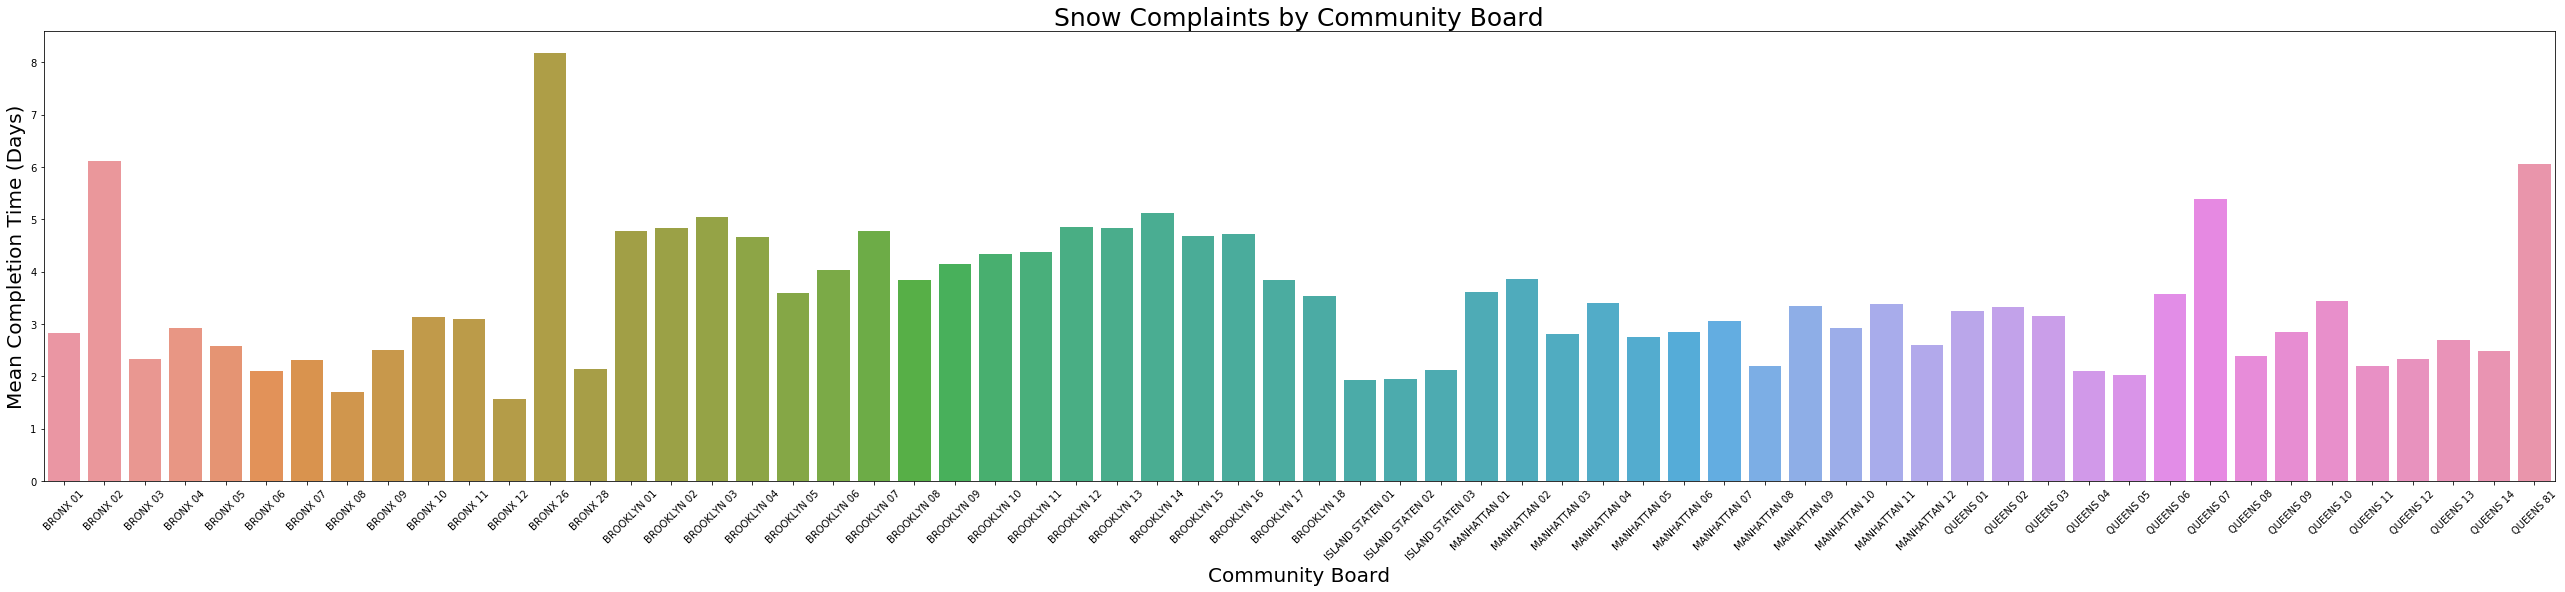

In [100]:
#snow complaints by community board

x= 'Community Board'
y= 'mean'



ax = sns.barplot(x, y, data=snow_grouped)
ax.set_title('Snow Complaints by Community Board', fontsize=25)
ax.set_xlabel("Community Board",fontsize=20)
ax.set_ylabel("Mean Completion Time (Days)",fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.gcf().set_size_inches(45, 8.27)
plt.show()

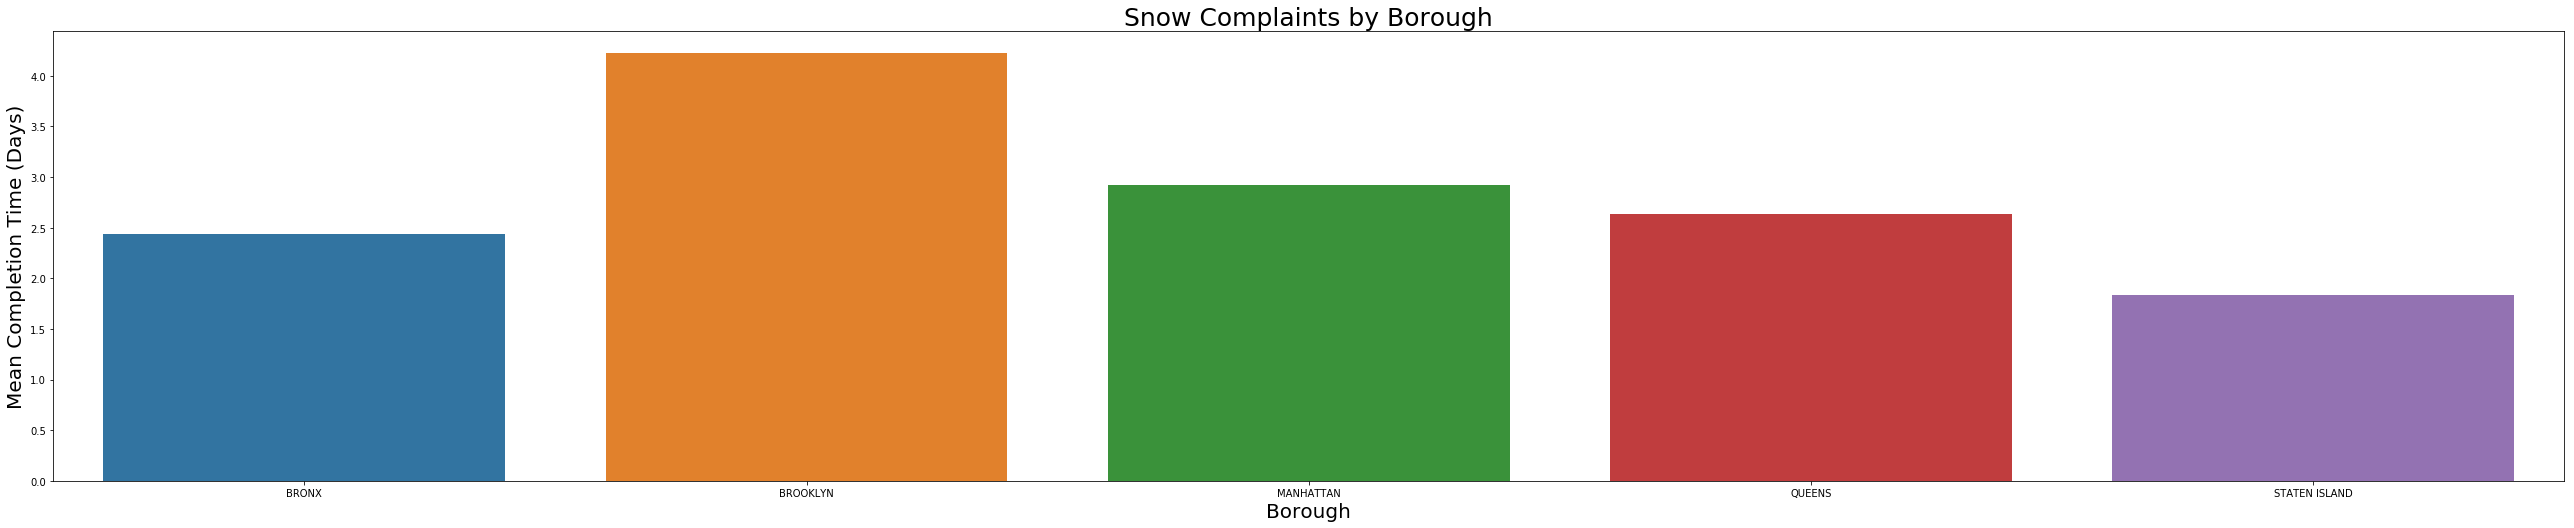

In [101]:
#snow complaints by borough


x= 'Borough'
y= 'mean'



ax = sns.barplot(x, y, data=snow_borough)
ax.set_title('Snow Complaints by Borough', fontsize=25)
ax.set_xlabel("Borough",fontsize=20)
ax.set_ylabel("Mean Completion Time (Days)",fontsize=20)
plt.gcf().set_size_inches(45, 8.27)
plt.show()

min days:  0.0 
 max days:  91.73 
 mean:  2.85 
 median:  2.3 
 iqr:  2.47 
 % unobserved:  0.15


/home/ben/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


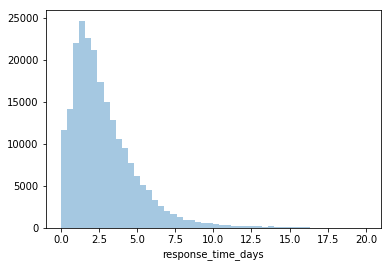

In [102]:
# HPD Heat and Hot Water Complaints – response window? What percentage are unobserved?

heat_water =  db[db['Complaint Type']== 'HEAT/HOT WATER']
heat_water = heat_water[heat_water.response_time_days >0]
print(
    'min days: ',round(heat_water.response_time_days.min(),2),'\n',
    'max days: ',round(heat_water.response_time_days.max(),2),'\n',
    'mean: ',round(heat_water.response_time_days.mean(),2),'\n',
    'median: ',round(heat_water.response_time_days.median(),2),'\n',
    'iqr: ',round(iqr(heat_water.response_time_days),2),'\n',
    '% unobserved: ', round(len(heat_water[heat_water.res_desc == 'did_not_observe'])/len(heat_water),2)
)

sns.distplot(heat_water[heat_water.response_time_days<20].response_time_days, kde=False)

In [103]:
# HPD What types of complaints are consistently (if any) going unobserved?

df_hpd = db[db.Agency =='HPD']
grouped_hpd = df_hpd.groupby(['Complaint Type','res_desc'])
grouped_hpd = grouped_hpd.Agency.aggregate('count').to_frame().reset_index()
grouped_hpd

pivot_hpd = grouped_hpd.pivot_table(index='Complaint Type',columns='res_desc',aggfunc=sum)
pivot_hpd.fillna(0,inplace=True)
pivot_hpd.columns = pivot_hpd.columns.droplevel()
pivot_hpd.columns.name = None
pivot_hpd.reset_index(inplace=True)
#pivot_hpd = pivot_hpd.drop(pivot_hpd.columns[[7,8,9]], axis=1)
pivot_hpd['total'] = pivot_hpd.sum(axis=1)
pivot_hpd['unobserved_rate'] = round(pivot_hpd.did_not_observe/pivot_hpd.total,2)
pivot_hpd = pivot_hpd.sort_values(by= 'unobserved_rate', ascending = False)
pivot_hpd.to_csv('hpd_unobserved_rate.csv')

In [104]:
# HPD Lead Complaints – response window? Resolution?
tmp = db[(db.Agency == "HPD")&(db.Descriptor.str.contains('Lead')==True)]
tmp

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Description,Resolution Action Updated Date,Community Board,BBL,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Open Data Channel Type,Park Facility Name,Park Borough,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location,Response Time,response_time_days,response_time_hours,response_time_minutes,response_time_seconds,under_120,res_desc
288343,38398462,2018-02-06 14:04:49,2018-02-12 11:59:17,HPD,Department of Housing Preservation and Develop...,HPD Literature Request,New Lead Law Rights and Requirements,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Closed,02/19/2018 11:58:45 AM,the literature has been mailed. if it has not ...,02/12/2018 11:58:45 AM,0 Unspecified,NaN,Unspecified,NaN,NaN,PHONE,Unspecified,Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 days 21:54:28,5.912824,141.907778,8514.466667,510868.0,0,fixed
671854,38849728,2018-04-03 10:43:43,2018-04-04 10:46:25,HPD,Department of Housing Preservation and Develop...,HPD Literature Request,New Lead Law Rights and Requirements,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Closed,04/04/2018 10:43:43 AM,the literature will be emailed within 24 hours...,04/03/2018 10:45:30 AM,0 Unspecified,NaN,Unspecified,NaN,NaN,PHONE,Unspecified,Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1 days 00:02:42,1.001875,24.045000,1442.700000,86562.0,0,ongoing
770016,38966357,2018-04-17 10:36:12,2018-04-18 10:39:28,HPD,Department of Housing Preservation and Develop...,HPD Literature Request,New Lead Law Rights and Requirements,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Closed,04/18/2018 10:36:12 AM,the literature will be emailed within 24 hours...,04/17/2018 10:38:36 AM,0 Unspecified,NaN,Unspecified,NaN,NaN,PHONE,Unspecified,Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1 days 00:03:16,1.002269,24.054444,1443.266667,86596.0,0,ongoing
791339,38990006,2018-04-20 07:02:08,2018-04-23 11:37:58,HPD,Department of Housing Preservation and Develop...,HPD Literature Request,New Lead Law Rights and Requirements,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Closed,04/30/2018 11:37:54 AM,the literature has been mailed. if it has not ...,04/23/2018 11:37:54 AM,0 Unspecified,NaN,Unspecified,NaN,NaN,PHONE,Unspecified,Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3 days 04:35:50,3.191551,76.597222,4595.833333,275750.0,0,fixed
981864,39202911,2018-05-16 18:01:05,2018-05-17 18:04:09,HPD,Department of Housing Preservation and Develop...,HPD Literature Request,New Lead Law Rights and Requirements,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Closed,05/17/2018 06:01:05 PM,the literature will be emailed within 24 hours...,05/16/2018 06:03:18 PM,0 Unspecified,NaN,Unspecified,NaN,NaN,PHONE,Unspecified,Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1 days 00:03:04,1.002130,24.051111,1443.066667,86584.0,0,ongoing
1583369,39915679,2018-08-03 15:24:57,2018-08-04 15:27:19,HPD,Department of Housing Preservation and Develop...,HPD Literature Request,New Lead Law Rights and Requirements,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Closed,08/04/2018 03:24:57 PM,the literature will be emailed within 24 hours...,08/03/2018 03:26:54 PM,0 Unspecified,NaN,Unspecified,NaN,NaN,PHONE,Unspecified,Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1 days 00:02:22,1.001644,24.039444,1442.366667,86542.0,0,ongoing
1946726,40333274,2018-09-20 21:43:42,2018-09-24 12:42:29,HPD,Department of Housing Preservation and Develop...,HPD Literature Request,New Lead Law Rights and Requirements,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Closed,10/01/2018 12:42:23 PM,the literature has been mailed. if it has not ...

In [105]:
# DEP Lead Kit Request – response window? Resolutions? Follow-up with Kit results?

lead.res_desc.value_counts()

fixed              3197
no_action_taken       3
did_not_observe       2
Name: res_desc, dtype: int64

In [106]:
# DOT Pothole Complaints – response window? Resolution? How many pothole complaints get sent to DEP (can we assume these are in fact sinkholes)? What is the DEP Resolution?

db[db['Complaint Type'] =='Street Condition']['Descriptor'].value_counts()

db[db.Descriptor == 'Pothole']['Resolution Description'].value_counts()

print(
    'min days: ',round(db[db.Descriptor == 'Pothole'].response_time_days.min(),2),'\n',
    'max days: ',round(db[db.Descriptor == 'Pothole'].response_time_days.max(),2),'\n',
    'mean: ',round(db[db.Descriptor == 'Pothole'].response_time_days.mean(),2),'\n',
    'median: ',round(db[db.Descriptor == 'Pothole'].response_time_days.median(),2),'\n',
    'iqr: ',round(iqr(db[db.Descriptor == 'Pothole'].response_time_days),2),'\n',
    '% unobserved: ', round(len(db[(db.Descriptor == 'Pothole')&(db.res_desc == 'did_not_observe')])/len(db[db.Descriptor == 'Pothole']),2)
)

min days:  -0.35 
 max days:  319.78 
 mean:  3.81 
 median:  1.29 
 iqr:  4.39 
 % unobserved:  0.1


In [107]:
#calculate how much of a the data set is covered by the classification system
db.res_desc.value_counts()

(622194+529260+480266+301716+188401+151018+142531+123513)/len(db)

0.9811817391684087

In [108]:
# NYPD Noise Complaints by Borough and Community Board

noise_nypd = db[(db.Agency == "NYPD")&(db['Complaint Type'].str.contains('Noise'))]
noise_board = noise_nypd.groupby('Community Board')
noise_board = noise_board.response_time_hours.aggregate(['count', 'mean', 'std']).reset_index()
noise_boro = noise_nypd.groupby('Borough')
noise_boro = noise_boro.response_time_hours.aggregate(['count', 'mean', 'std']).reset_index()


noise_board = noise_board[~noise_board['Community Board'].str.contains("Unspecified")]
noise_boro = noise_boro[~noise_boro['Borough'].str.contains("Unspecified")]


noise_board['Community Board'] = [reverseWords(x) for x in noise_board['Community Board']]
noise_board=noise_board.sort_values(by='Community Board')

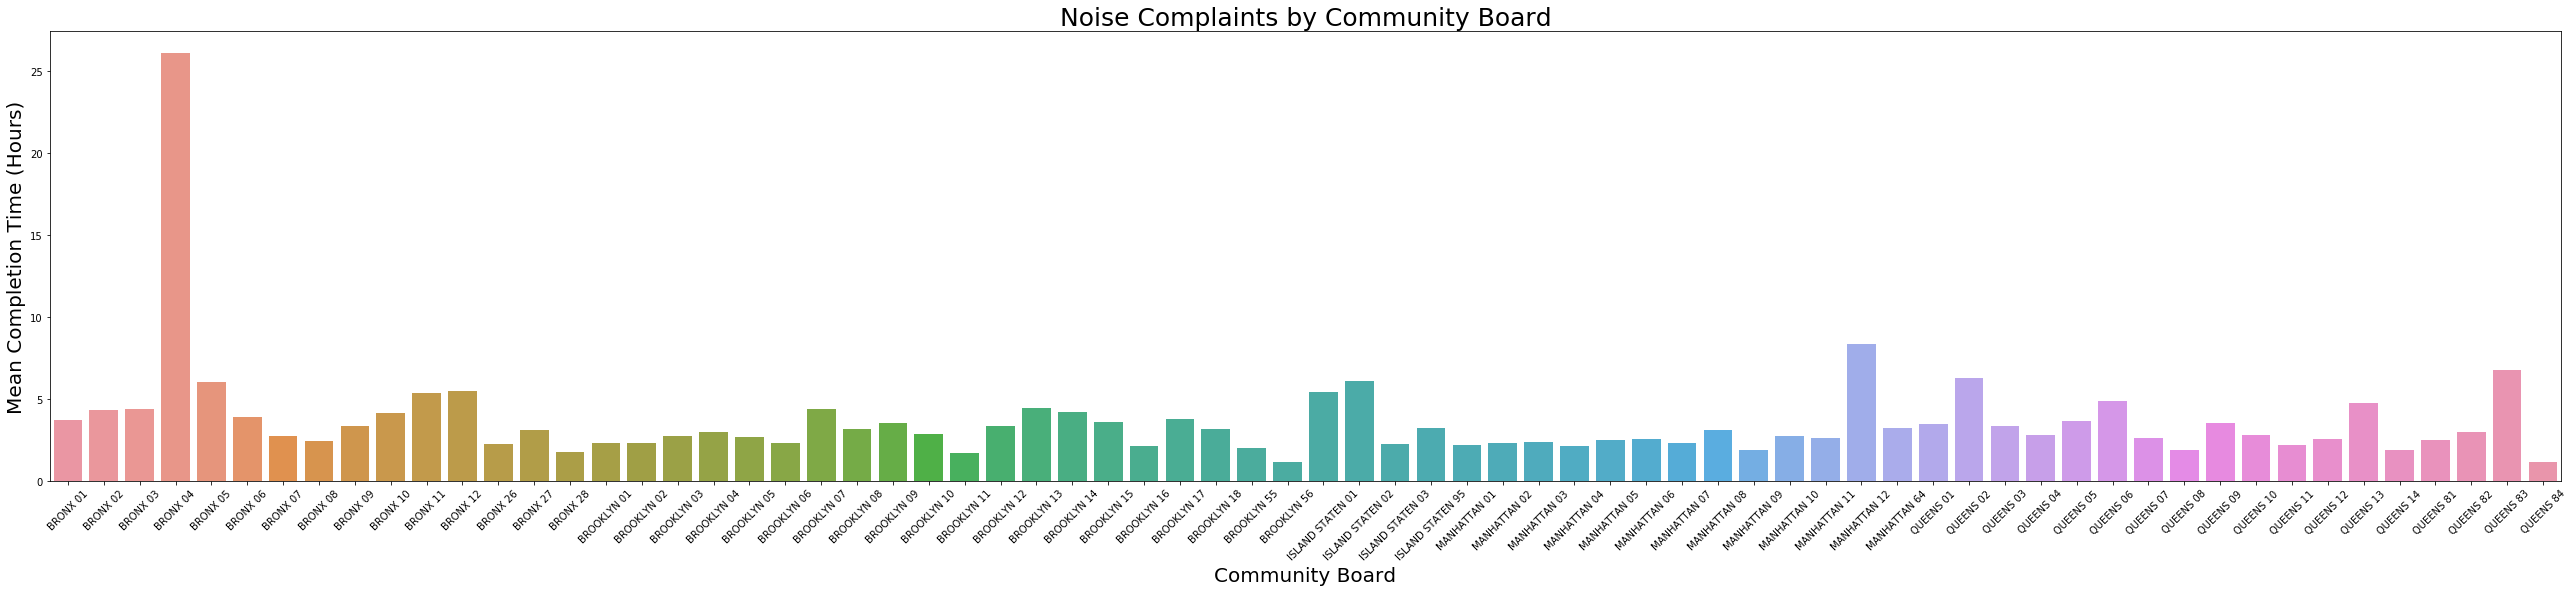

In [109]:
x= 'Community Board'
y= 'mean'



ax = sns.barplot(x, y, data=noise_board)
ax.set_title('Noise Complaints by Community Board', fontsize=25)
ax.set_xlabel("Community Board",fontsize=20)
ax.set_ylabel("Mean Completion Time (Hours)",fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.gcf().set_size_inches(45, 8.27)
plt.show()

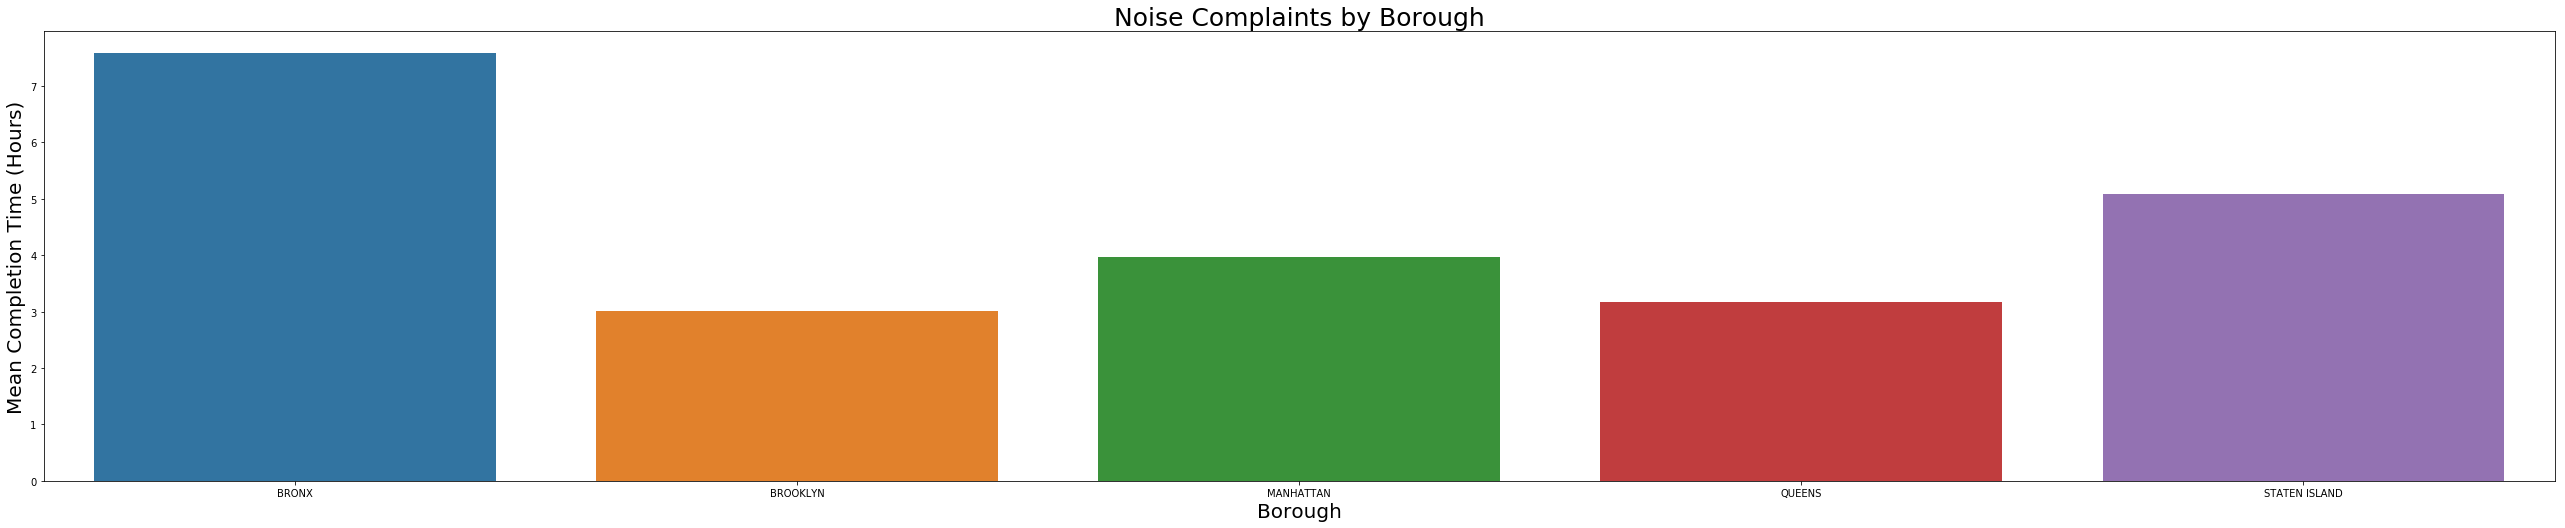

In [110]:
x= 'Borough'
y= 'mean'



ax = sns.barplot(x, y, data=noise_boro)
ax.set_title('Noise Complaints by Borough', fontsize=25)
ax.set_xlabel("Borough",fontsize=20)
ax.set_ylabel("Mean Completion Time (Hours)",fontsize=20)
plt.gcf().set_size_inches(45, 8.27)
plt.show()

In [111]:
#median, mean and iqr response times for 04 Bronx in hours
print(
    noise_nypd[noise_nypd['Community Board'] == "04 BRONX"].response_time_hours.median(),
    noise_nypd[noise_nypd['Community Board'] == "04 BRONX"].response_time_hours.mean(),
    iqr(noise_nypd[noise_nypd['Community Board'] == "04 BRONX"].response_time_hours)
)

15.009583333333333 26.138049103504482 27.447430555555556
